<a href="https://colab.research.google.com/github/ZeeeeCS/Sales-Forcasting-For-retail-store/blob/main/ThirdSalesForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install needed libraries**

In [ ]:
pip install prophet

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


# **Libraries Import**

**First, we import all the necessary libraries. This includes pandas for data manipulation, numpy for numerical operations, matplotlib and seaborn for static visualizations, plotly for interactive visualizations, sklearn.metrics for evaluating our model, prophet for the time series forecasting model itself, and calendar from pandas to help us identify holidays. We also import warnings to suppress unnecessary output messages and set some default styles for our plots.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import tensorflow as tf
import keras_tuner as kt
import matplotlib.dates as mdates
from prophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
# Ignore warnings
warnings.filterwarnings('ignore')
# consistent styles for matplotlib plots
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

**we define a helper function called mean_absolute_percentage_error (MAPE). MAPE is a common metric used to evaluate the accuracy of forecasts. It measures the average percentage difference between the actual values and the predicted values. We handle potential division by zero by replacing any true zero values with a very small number.**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = np.where(y_true == 0, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Uploading API Token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedsayedjp","key":"09239f6bbcc96a5d4b5bdc1288f535ea"}'}

**Here, we set up the necessary directory and permissions for the Kaggle API to work, downloads the specified dataset ('retail-store-inventory-forecasting-dataset'), and unzips the downloaded file.**

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download anirudhchauhan/retail-store-inventory-forecasting-dataset

Dataset URL: https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset
License(s): CC0-1.0


In [ ]:
!unzip retail-store-inventory-forecasting-dataset.zip

Archive:  retail-store-inventory-forecasting-dataset.zip
  inflating: retail_store_inventory.csv  


In [ ]:
# load the Data into DataFrame
data_sales=pd.read_csv('/content/retail_store_inventory.csv')

In [ ]:
# shows first 10 rows of the Data
data_sales.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [ ]:
# a concise summary of the DataFrame
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
# Check the dimensions of the DataFrame
data_sales.shape

(73100, 15)

In [ ]:
# Convert object-type columns to Categorical Columns
data_sales[['Region','Category','Seasonality','Weather Condition']]=data_sales[['Region','Category','Seasonality','Weather Condition']].astype('category')

# **Cleaning and Preprocessing**

In [ ]:
# confirm the data type changes
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Date                73100 non-null  object  
 1   Store ID            73100 non-null  object  
 2   Product ID          73100 non-null  object  
 3   Category            73100 non-null  category
 4   Region              73100 non-null  category
 5   Inventory Level     73100 non-null  int64   
 6   Units Sold          73100 non-null  int64   
 7   Units Ordered       73100 non-null  int64   
 8   Demand Forecast     73100 non-null  float64 
 9   Price               73100 non-null  float64 
 10  Discount            73100 non-null  int64   
 11  Weather Condition   73100 non-null  category
 12  Holiday/Promotion   73100 non-null  int64   
 13  Competitor Pricing  73100 non-null  float64 
 14  Seasonality         73100 non-null  category
dtypes: category(4), float64(3), int64(5)

**We create a boxplot to visualize how 'Units Sold' are distributed across different 'Regions'.**

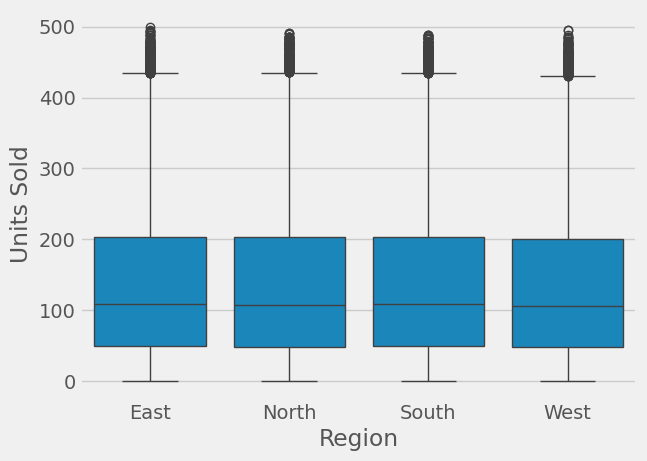

In [ ]:
# Boxplots the distribution of 'Units Sold' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Sold')
plt.show()

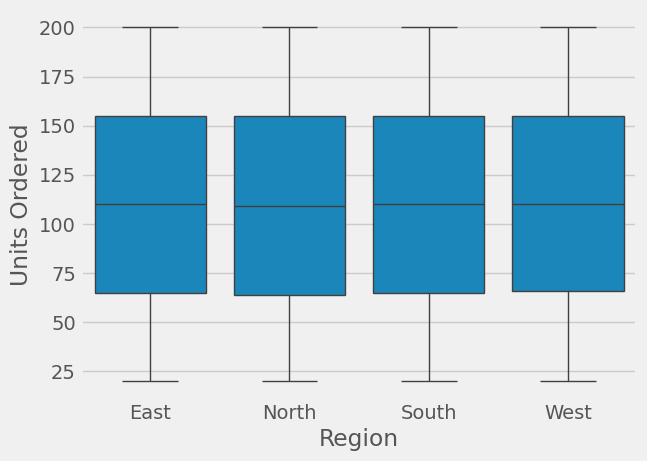

In [ ]:
# Boxplots the distribution of 'Units Ordered' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Ordered')
plt.show()

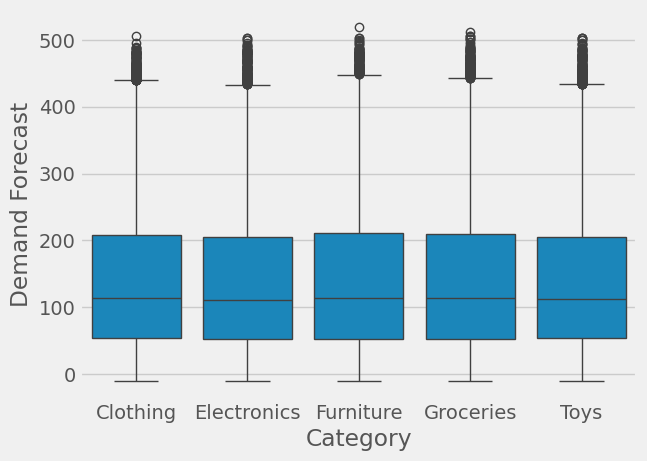

In [ ]:
# Boxplot for 'Demand Forecast' by product 'Category'
sns.boxplot(data=data_sales,x='Category',y='Demand Forecast')
plt.show()

In [ ]:
# Check for Missing Values
data_sales.isnull().sum()

,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Demand Forecast,0
Price,0


In [ ]:
# Descriptive Statistics
data_sales.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


**to explore the relationships between different numerical variables, we first need to ensure all columns are numeric. We create a copy of the data, drop non-numeric identifiers ('Date', 'Store ID', 'Product ID'), and then convert the categorical columns ('Region', 'Category', etc.) into numerical representations using .cat.codes. Each unique category gets assigned an integer code.**

In [ ]:
# Correlation Analysis
corrlation=data_sales.copy()
corrlation.drop(columns=['Date','Store ID','Product ID'],inplace=True)

for col in ['Region','Category','Seasonality','Weather Condition']:
    corrlation[col]=corrlation[col].astype('category').cat.codes

corrlation.corr()

,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
Category,1.000000,0.000841,0.001439,0.000512,-0.001686,0.000495,0.001375,-0.001784,-0.000624,-0.000864,0.000947,-0.001474
Region,0.000841,1.000000,-0.006837,-0.003109,0.003172,-0.002467,-0.003576,-0.002696,0.000209,-0.001074,-0.003389,-0.000785
Inventory Level,0.001439,-0.006837,1.000000,0.589995,0.001060,0.588561,0.009140,0.004889,0.001898,0.003411,0.009365,-0.003425
Units Sold,0.000512,-0.003109,0.589995,1.000000,-0.000930,0.996853,0.001082,0.002576,0.004688,-0.000374,0.001259,-0.003324
Units Ordered,-0.001686,0.003172,0.001060,-0.000930,1.000000,-0.001102,0.004212,-0.000938,-0.001064,0.005446,0.004596,0.003492
Demand Forecast,0.000495,-0.002467,0.588561,0.996853,-0.001102,1.000000,0.000675,0.002338,0.004768,-0.000526,0.000844,-0.003109
Price,0.001375,-0.003576,0.009140,0.001082,0.004212,0.000675,1.000000,0.001509,-0.007715,0.002309,0.993900,0.005095
Discount,-0.001784,-0.002696,0.004889,0.002576,-0.000938,0.002338,0.001509,1.000000,-0.002302,-0.000852,0.001958,-0.004622
Weather Condition,-0.000624,0.000209,0.001898,0.004688,-0.001064,0.004768,-0.007715,-0.002302,1.000000,-0.002408,-0.007440,0.003646
Holiday/Promotion,-0.000864,-0.001074,0.003411,-0.000374,0.005446,-0.000526,0.002309,-0.000852,-0.002408,1.000000,0.001890,-0.001081


# **Visualisation**

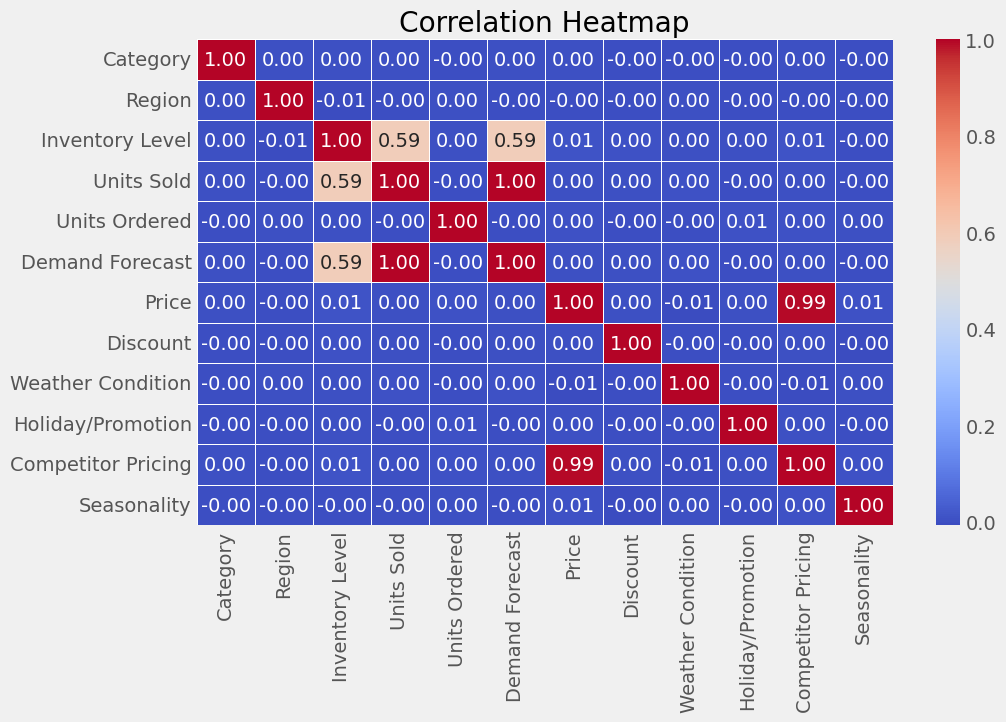

In [ ]:
# a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corrlation.corr(),annot=True,cmap='coolwarm',linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

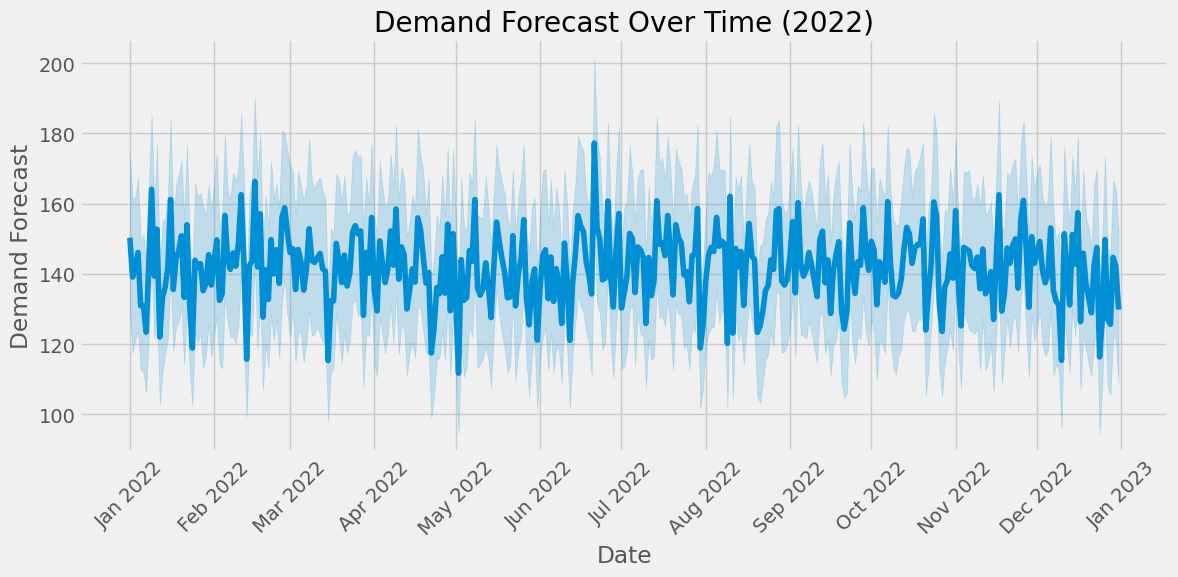

In [ ]:
# Convert 'Date' column to datetime format
data_sales['Date'] = pd.to_datetime(data_sales['Date'])

# Now filter the correct date range
filtered_data = data_sales[(data_sales['Date'] >= '2022-01-01') & (data_sales['Date'] <= '2022-12-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Date', y='Demand Forecast')

plt.title('Demand Forecast Over Time (2022)')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')

# line plot showing the 'Demand Forecast' over time for the filtered 2022 data
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

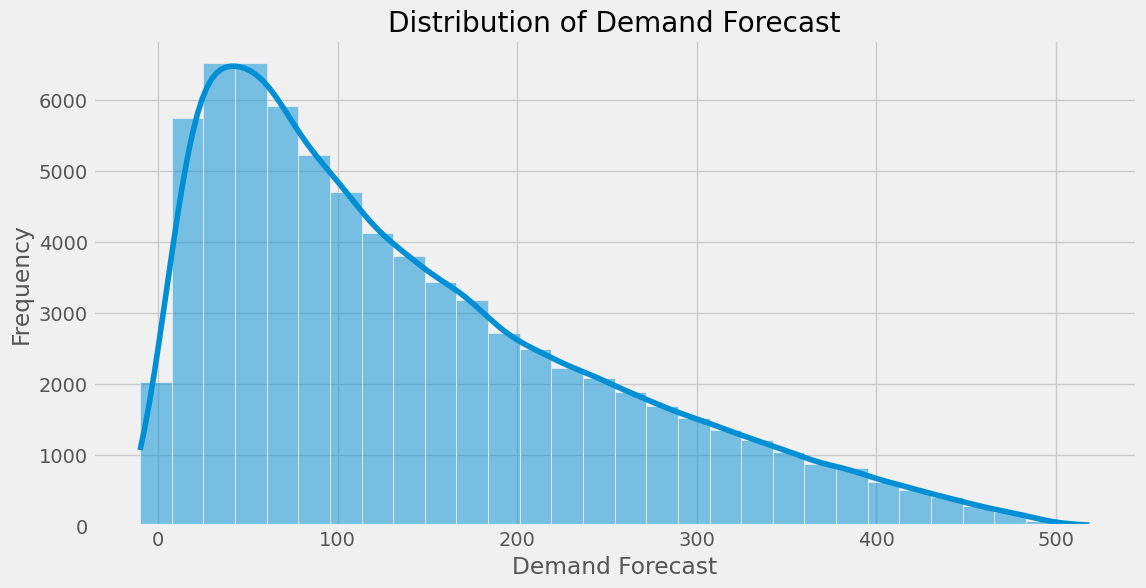

In [ ]:
# A histogram helps us understand the distribution of 'Demand Forecast' values to see how frequently different forecast levels occur.
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Demand Forecast', bins=30, kde=True)
plt.title('Distribution of Demand Forecast')
plt.xlabel('Demand Forecast')
plt.ylabel('Frequency')
plt.show()

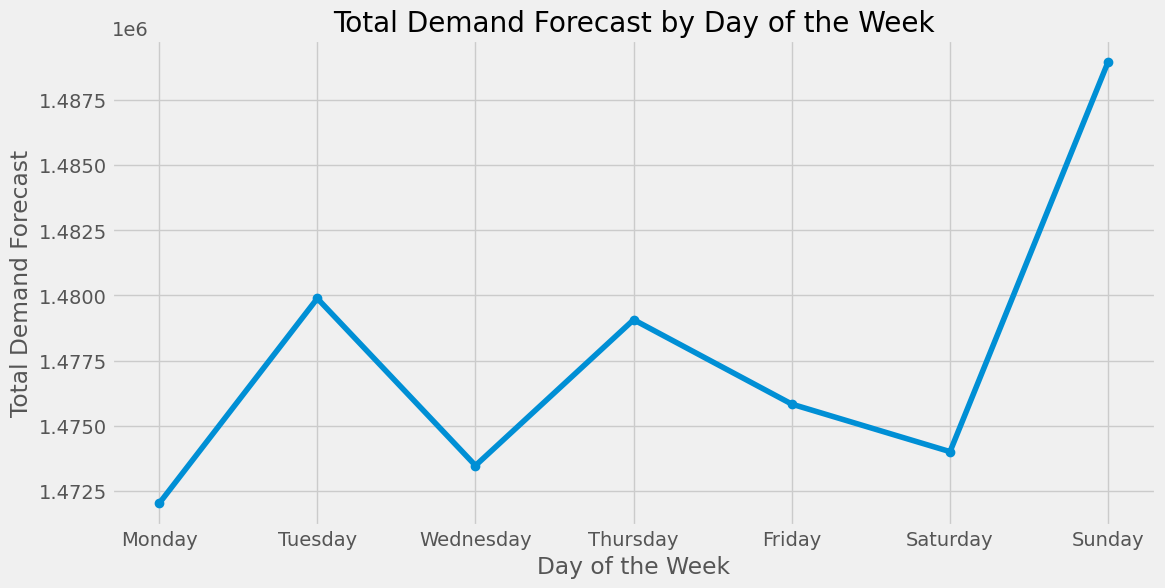

In [ ]:
# Extract day of the week from the Date column
data_sales['DayOfWeek'] = pd.to_datetime(data_sales['Date']).dt.day_name()

# Group by day of the week and sum the uDemand Forecast
daily_sales = data_sales.groupby('DayOfWeek')['Demand Forecast'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Total demand forecast for each day of the week
plt.figure(figsize=(12, 6))
daily_sales.plot(kind='line', marker='o')
plt.title('Total Demand Forecast by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Demand Forecast')
plt.grid(True)
plt.show()

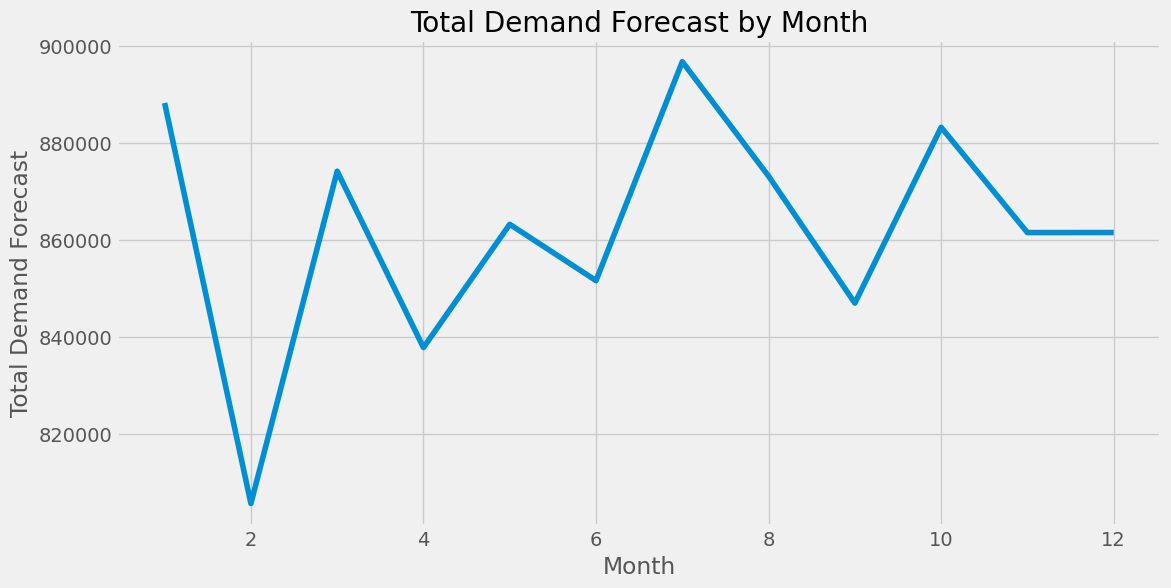

In [ ]:
# Extract the month number (1-12) from the 'Date' column
data_sales['Month'] = pd.to_datetime(data_sales['Date']).dt.month

# line plot showing the total 'Demand Forecast' aggregated by month
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_sales, x='Month', y='Demand Forecast', estimator=sum, ci=None)
plt.title('Total Demand Forecast by Month')
plt.xlabel('Month')
plt.ylabel('Total Demand Forecast')
plt.show()

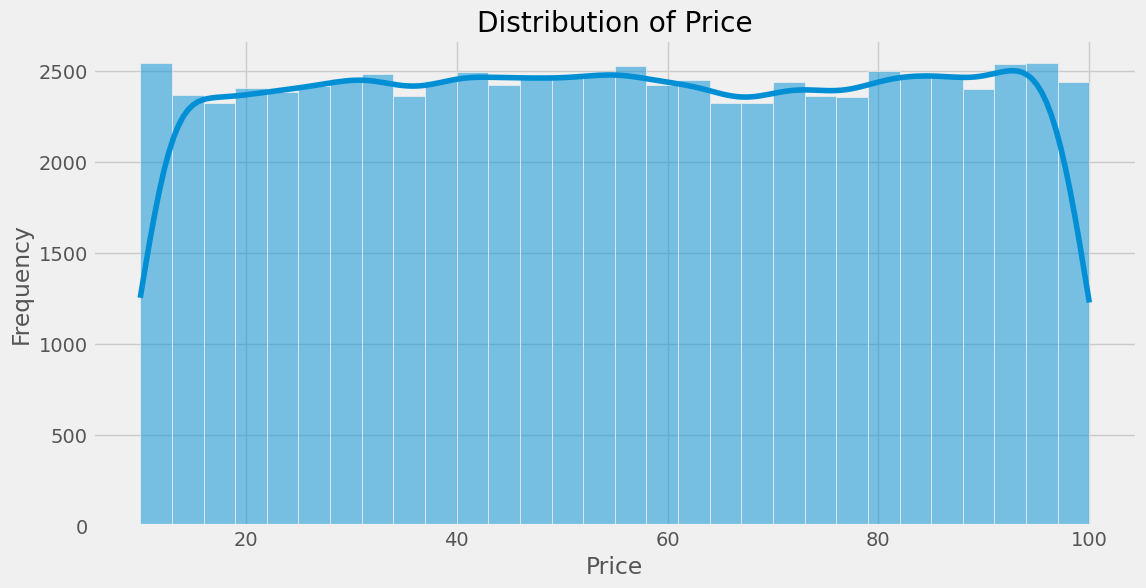

In [ ]:
# distribution of 'Price' values
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Price', bins=30, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

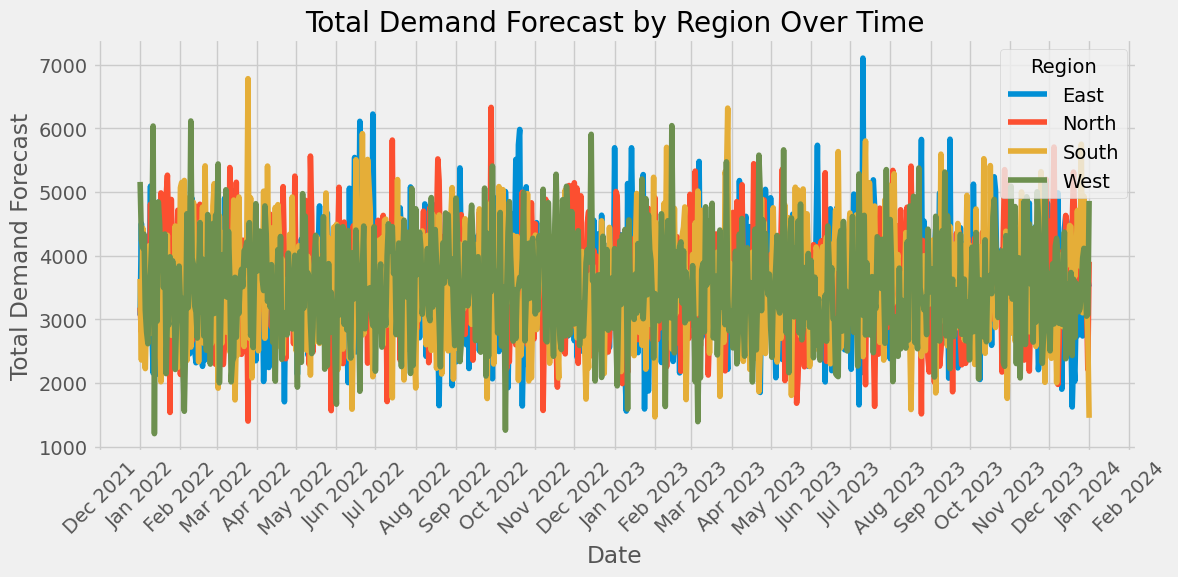

In [ ]:
# line plot showing the total 'Demand Forecast' over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_sales, x='Date', y='Demand Forecast', hue='Region', estimator=sum, ci=None)
plt.title('Total Demand Forecast by Region Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand Forecast')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"
plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to prevent cutoff
plt.show()

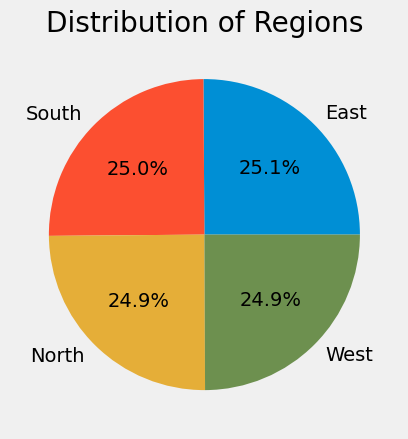

In [ ]:
# pie chart showing the proportion of records for each 'Region'
plt.pie(data_sales['Region'].value_counts(), labels=data_sales['Region'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Regions')
plt.show()

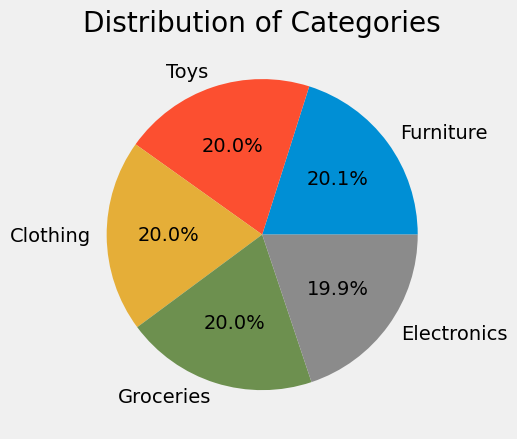

In [ ]:
# pie chart showing the proportion of records for each product 'Category'
plt.pie(data_sales['Category'].value_counts(), labels=data_sales['Category'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.show()

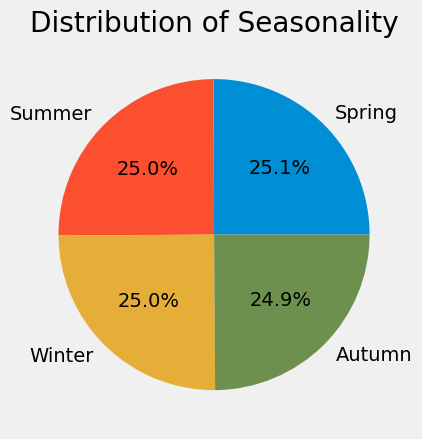

In [ ]:
# pie chart showing the proportion of records for each Season
plt.pie(data_sales['Seasonality'].value_counts(), labels=data_sales['Seasonality'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Seasonality')
plt.show()

In [ ]:
grouped_data_weather = data_sales.groupby(['Category', 'Weather Condition'])['Demand Forecast'].sum().reset_index()

fig=px.bar(grouped_data_weather,x='Category',y='Demand Forecast',color='Weather Condition',color_discrete_map={
        'Rainy': 'blue',
        'Sunny': 'orange',
        'Cloudy': 'grey',
        'Snowy': 'lightblue'
    })
fig.show()

In [ ]:
grouped_data_area = data_sales.groupby(['Date', 'Region'])['Demand Forecast'].sum().reset_index()
px.area(grouped_data_area,x='Date',y='Demand Forecast',color='Region')

In [ ]:
grouped_data_region = data_sales.groupby(['Category', 'Region'])['Demand Forecast'].sum().reset_index()
px.bar(grouped_data_region,x='Category',y='Demand Forecast',color='Region',barmode='group')

In [ ]:
grouped_data_seasonality = data_sales.groupby(['Category', 'Seasonality'])['Demand Forecast'].sum().reset_index()
px.bar(grouped_data_seasonality,x='Category',y='Demand Forecast',color='Seasonality',barmode='group')


# **Feature Engineering**

**to understand the time range, Check the minimum and maximum dates in the dataset.**

In [ ]:
data_sales['Date'].min(),data_sales['Date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'))

**Prophet requires specific column names: 'ds' for date and 'y' for the value to forecast.**

**We also aggregate the data to the daily level, as Prophet works well with daily data.**

In [ ]:
# Prepare Prophet Data by Creating a copy to work with
daily_df = data_sales.copy()
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Group by day: total demand per date to get total daily demand
daily_df = daily_df.groupby('Date', as_index=False)['Demand Forecast'].sum()

# Add engineered features
daily_df['day_of_week'] = daily_df['Date'].dt.dayofweek
daily_df['month'] = daily_df['Date'].dt.month
daily_df['is_weekend'] = daily_df['day_of_week'].isin([5, 6]).astype(int)

# Rename columns to 'ds' and 'y' as required by Prophet
daily_df = daily_df.rename(columns={'Date': 'ds', 'Demand Forecast': 'y'})

In [ ]:
daily_df.shape

(731, 5)

In [ ]:
# Define a split date to separate training and testing data
split_date = '2023-10-01'
# Create the training set (data before the split date)
train_df = daily_df[daily_df['ds'] < split_date].copy()
# Create the testing set (data on or after the split date)
test_df = daily_df[daily_df['ds'] >= split_date].copy()

**Visualize the train/test split**

Rename columns for clarity in the legend.

Set index to 'ds' for joining and plotting time series.

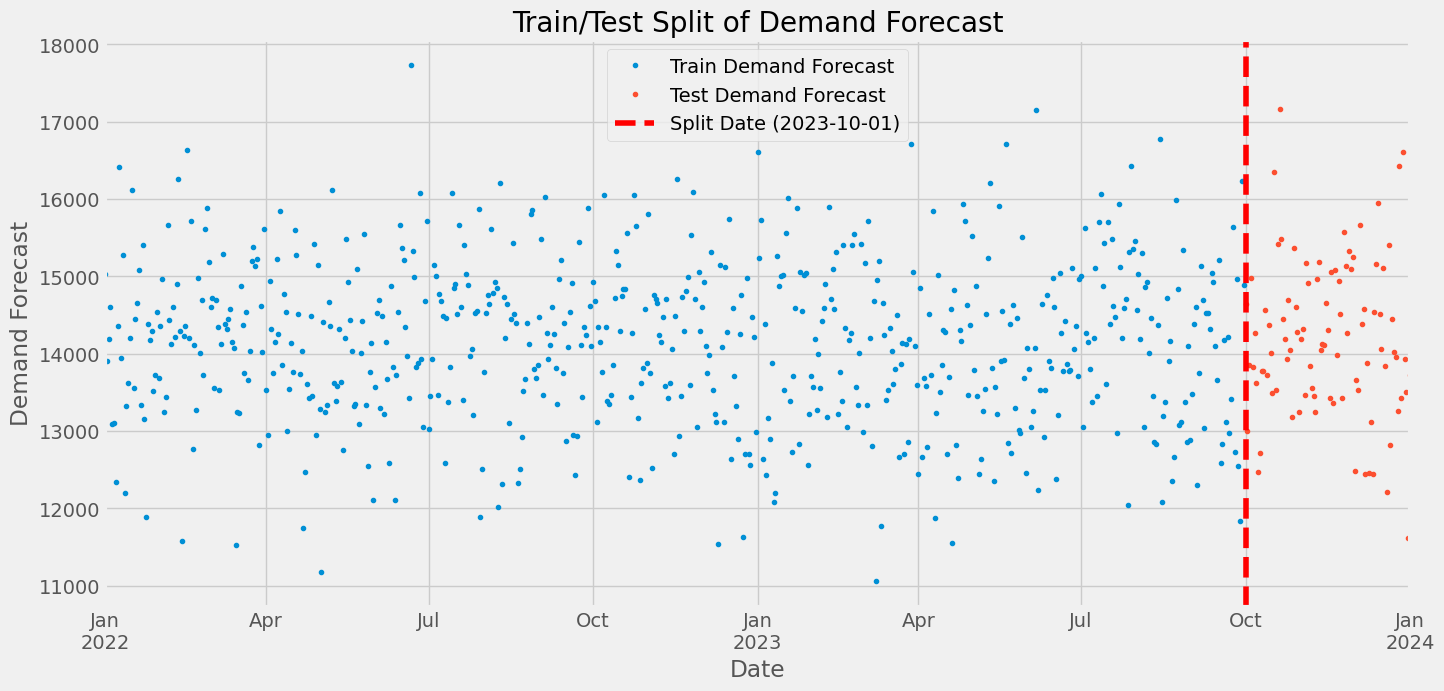

In [ ]:
plot_df = train_df.set_index('ds')[['y']].rename(columns={'y':'Train Demand Forecast'}) \
          .join(test_df.set_index('ds')[['y']].rename(columns={'y':'Test Demand Forecast'}), how='outer')

plot_df.plot(figsize=(15, 7), title='Train/Test Split of Demand Forecast', style=['.', '.']) # Use dots for actual data points
# Add a vertical line at the split date
plt.axvline(pd.to_datetime(split_date), color='r', linestyle='--', label=f'Split Date ({split_date})')
plt.ylabel('Demand Forecast') # Add y-axis label
plt.xlabel('Date') # Add x-axis label
plt.legend()
plt.show()

In [ ]:
# Check the shapes (number of rows/days) in the training and testing sets
test_df.shape,train_df.shape

((93, 5), (638, 5))

# **Modeling and Trends**

In [ ]:
# Create the Prophet Model with Regressors
m = Prophet()
m.add_regressor('day_of_week')
m.add_regressor('month')
m.add_regressor('is_weekend')

# Train the model
m.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

# Create feature dataframe and forecast
future = m.make_future_dataframe(periods=len(test_df), freq='D')
future['day_of_week'] = future['ds'].dt.dayofweek
future['month'] = future['ds'].dt.month
future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)

forecast = m.predict(future)

# Evaluation the Model
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/_bm_9rbv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/08jpmt0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25005', 'data', 'file=/tmp/tmp9tthk61y/_bm_9rbv.json', 'init=/tmp/tmp9tthk61y/08jpmt0p.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model45ufkgxz/prophet_model-20250424204613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 1024.59
MAE: 798.55
MAPE: 5.60%


**Trend and Seasonality Analysis**

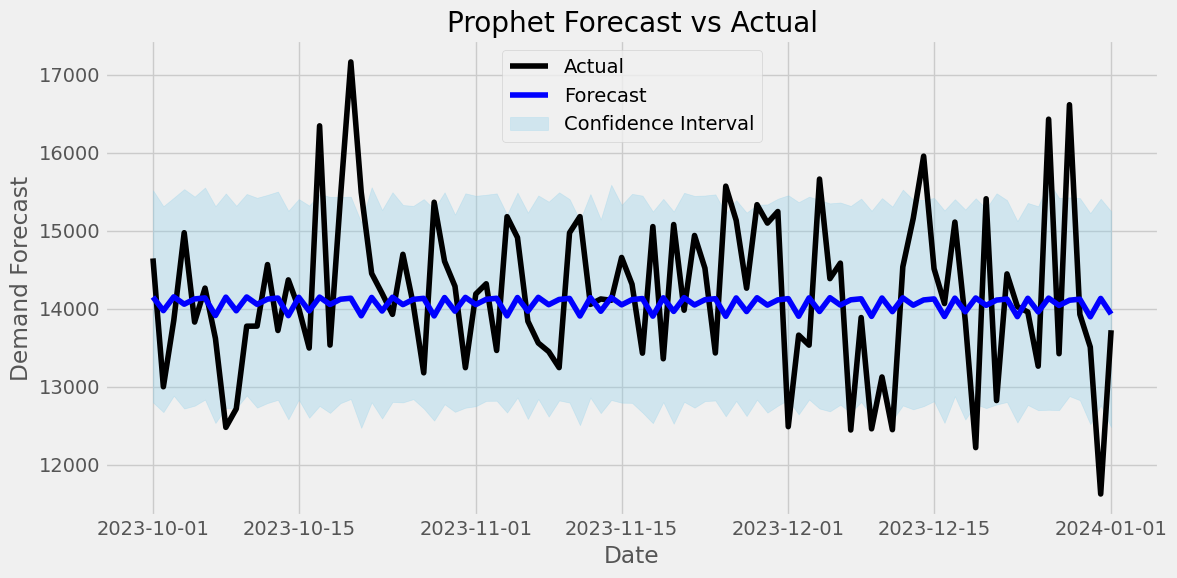

In [ ]:
# Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual', color='black')
plt.plot(test_df['ds'], y_pred, label='Forecast', color='blue')
plt.fill_between(test_df['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='skyblue', alpha=0.3, label='Confidence Interval')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

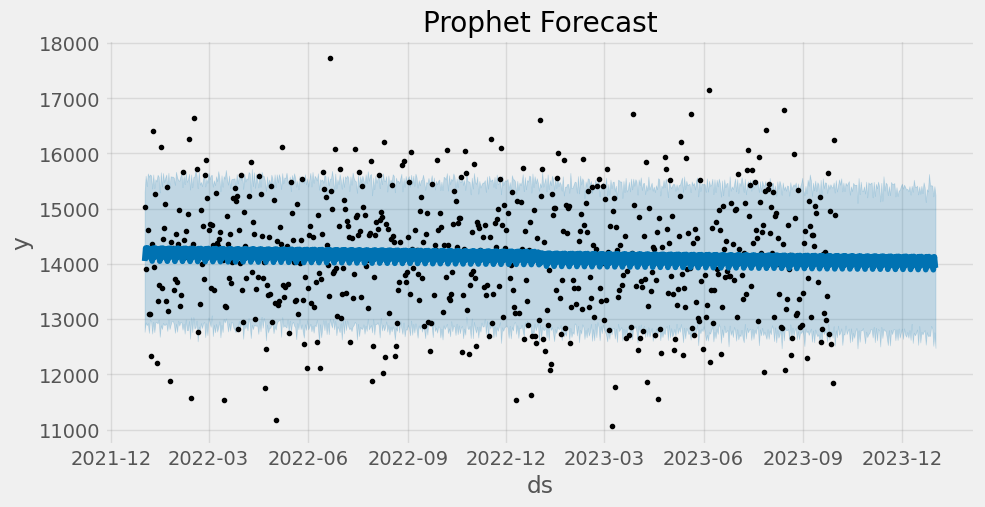

In [ ]:
# visualize the entire forecast (history + future)
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

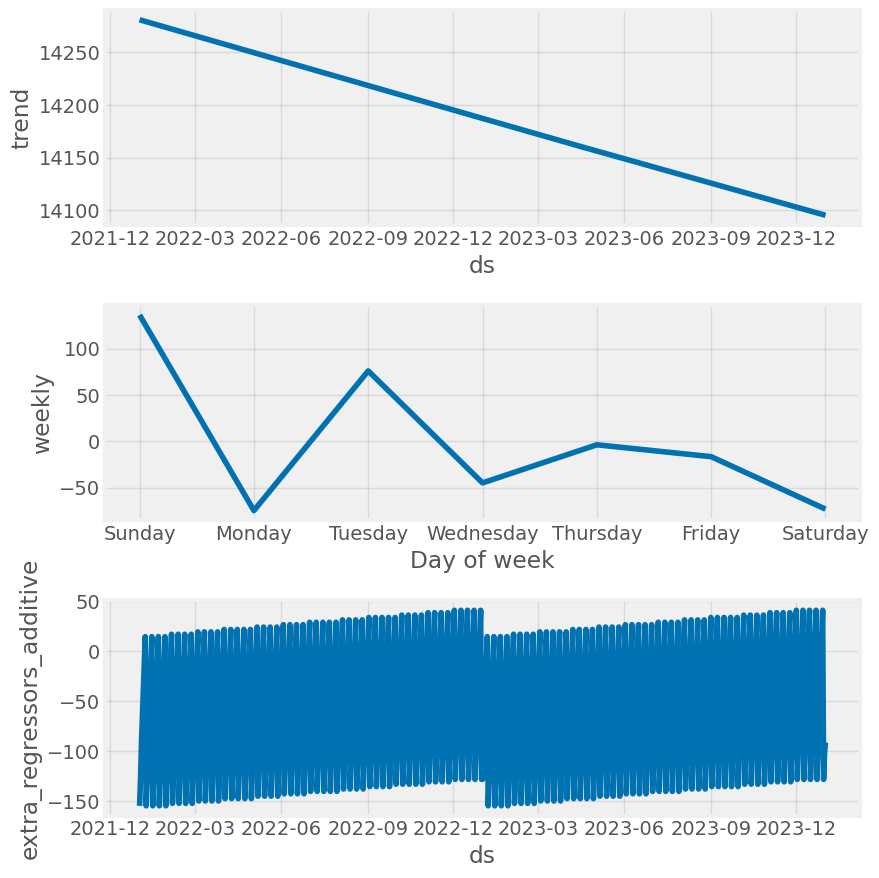

In [ ]:
# Shows trend/weekly seasonality, and regressor effects
fig = m.plot_components(forecast)
plt.show()

# **Model with Holidays**

**US federal holidays are extracted using the pandas calendar and formatted into a DataFrame compatible with Prophet.**

**These holidays span from the start of the historical data to the end of the forecast period to ensure they are properly considered during both model training and prediction.**

Note: Prophet model needs holidays for both training and prediction periods

In [ ]:
# Get US Holidays using pandas calendar
cal = calendar()

# Create a DataFrame of holidays within the range of our daily data
holidays = cal.holidays(start=daily_df.index.min(),
                        end=daily_df.index.max(),
                        return_name=True)

holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])

# Prophet requires columns 'ds' (date) and 'holiday' (name)
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
holiday_df.head()

,ds,holiday
0,1970-01-01,New Year's Day


Training the New Model

In [ ]:
# Cell time execution
%%time

model_with_holidays = Prophet(holidays=holiday_df)
# Add a regressors
model_with_holidays.add_regressor('day_of_week')
model_with_holidays.add_regressor('month')
model_with_holidays.add_regressor('is_weekend')

# Fit the model using the training data
model_with_holidays.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/_s51cix0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/qrmsv9yc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7562', 'data', 'file=/tmp/tmp9tthk61y/_s51cix0.json', 'init=/tmp/tmp9tthk61y/qrmsv9yc.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model5ryn9qzu/prophet_model-20250424204615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 85.8 ms, sys: 3.06 ms, total: 88.8 ms
Wall time: 136 ms


In [ ]:
# predictions on the test set
test_df_for_pred = test_df[['ds', 'day_of_week', 'month', 'is_weekend']]
# Predict using the model trained with holidays
test_fcst_with_hols = model_with_holidays.predict(df=test_df_for_pred)

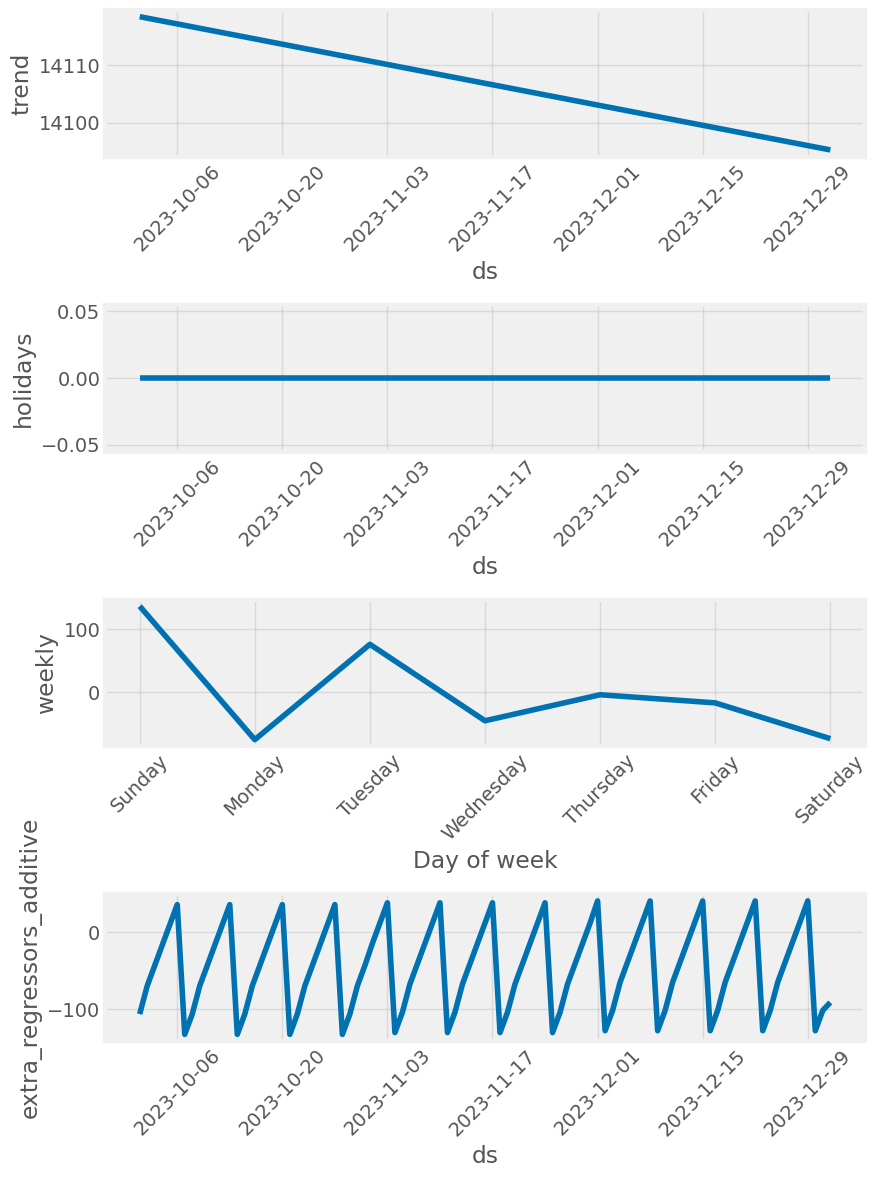

In [ ]:
# Plot components of the forecast
fig = model_with_holidays.plot_components(test_fcst_with_hols)

for ax in fig.get_axes():
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'October 2023 Predictions (with Holidays) vs Actual')

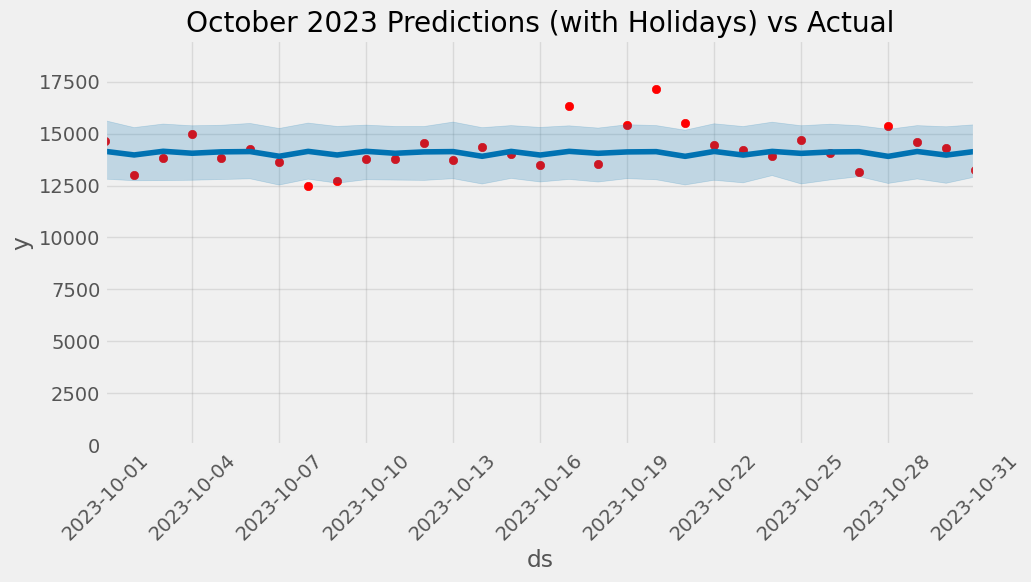

In [ ]:
# Plot the actual test data vs the forecast, focusing on the test period (Oct 2023)
fig, ax = plt.subplots(figsize=(10, 5))
# Plot actual values (red dots)
ax.scatter(test_df['ds'], test_df['y'], color='r', label='Actual')

# Plot the forecast from the holiday model using Prophet's plot function
fig = model_with_holidays.plot(test_fcst_with_hols, ax=ax)

# Set plot limits to focus on the test period
lower_bound = pd.to_datetime('2023-10-01')
upper_bound = pd.to_datetime('2023-10-31')

ax.set_xlim(lower_bound, upper_bound)
# Adjust y-limit for better visualization
ax.set_ylim(0, daily_df['y'].max() * 1.1) # Set ylim slightly larger than max observed y
plt.xticks(rotation=45)
ax.set_title('October 2023 Predictions (with Holidays) vs Actual')

In [ ]:
# Evaluate the model with holidays on the test set
y_true_test = test_df['y'].values
y_pred_test_hols = test_fcst_with_hols['yhat'].values

print("\nEvaluation Metrics (Model with Holidays):")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true_test, y_pred_test_hols)):.2f}")
print(f"MAE: {mean_absolute_error(y_true_test, y_pred_test_hols):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_true_test, y_pred_test_hols):.2f}%")


Evaluation Metrics (Model with Holidays):
RMSE: 1024.59
MAE: 798.55
MAPE: 5.60%


# **Future Forecasting**


In [ ]:
# forecast for the next 365 days (1 year)
future_forecast_df = model_with_holidays.make_future_dataframe(periods=365, freq='D')

# Add regressor values for these future dates
future_forecast_df['day_of_week'] = future_forecast_df['ds'].dt.dayofweek
future_forecast_df['month'] = future_forecast_df['ds'].dt.month
future_forecast_df['is_weekend'] = future_forecast_df['day_of_week'].isin([5, 6]).astype(int)

# Make predictions for the future period using the model trained with holidays and regressors
final_forecast = model_with_holidays.predict(future_forecast_df)

In [ ]:
# Display the first few rows of the future forecast (date and predicted value)
print("\nSample of Future Forecast (Next 365 days):")
# TAIL of the forecast to see the future dates and predictions
print(final_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail())


Sample of Future Forecast (Next 365 days):
             ds          yhat    yhat_lower    yhat_upper
998  2024-09-25  13964.377269  12661.806813  15341.738893
999  2024-09-26  14031.680174  12673.112648  15369.155832
1000 2024-09-27  14045.067904  12624.149804  15413.248359
1001 2024-09-28  13819.260075  12513.919488  15193.675800
1002 2024-09-29  14054.767601  12752.706135  15429.207741


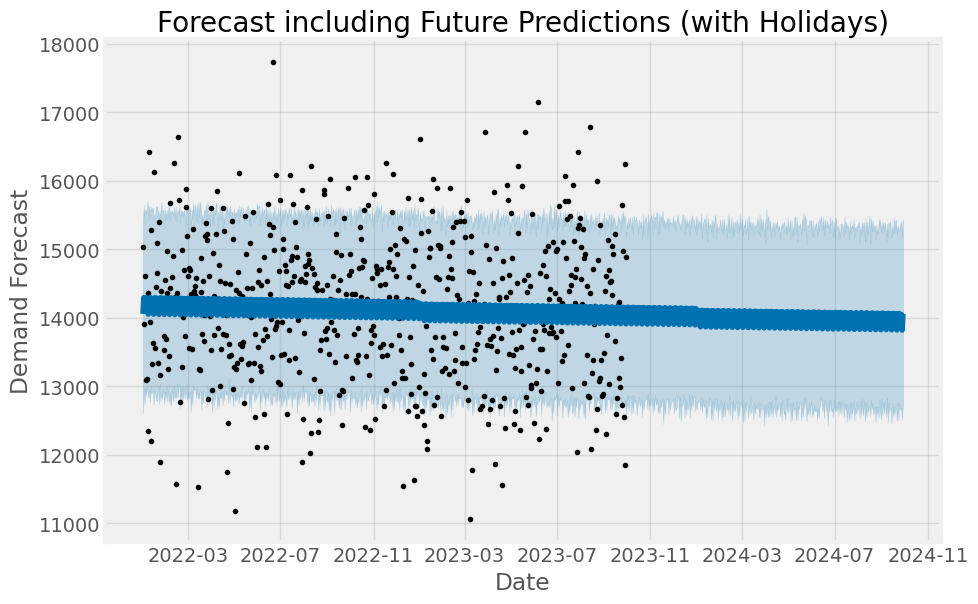

In [ ]:
# final forecast including the future period
fig_final = model_with_holidays.plot(final_forecast)
ax_final = fig_final.gca()
ax_final.set_title('Forecast including Future Predictions (with Holidays)')
plt.xlabel("Date")
plt.ylabel("Demand Forecast")
plt.show()

# **Hyper Paramaeter Tuning**

**Prophet doesn't fit directly into scikit-learn's GridSearchCV but there are alternatives (manual loops or Prophet's cross_validation)**

In [ ]:
# Store Baseline Prophet Results
prophet_baseline_metrics = {
    'Model': 'Prophet (Baseline w/ Holidays & Regressors)',
    'RMSE': 1024.59,
    'MAE': 798.55,
    'MAPE': 5.60
}

print("Baseline Prophet Metrics:")
print(prophet_baseline_metrics)

Baseline Prophet Metrics:
{'Model': 'Prophet (Baseline w/ Holidays & Regressors)', 'RMSE': 1024.59, 'MAE': 798.55, 'MAPE': 5.6}


**First we Tune the Tune Prophet changepoint_prior_scale (CPS) to get the best models' (RMSE, MAE, MAPE)**

In [ ]:
# Define values to try for changepoint_prior_scale
changepoint_scales_to_try = [0.01, 0.05, 0.1, 0.5] # Default is 0.05
results = []

for scale in changepoint_scales_to_try:
    print(f"--- Training with changepoint_prior_scale = {scale} ---")

    # Initialize model with holidays and the specific scale
    m_tuned = Prophet(
        holidays=holiday_df,
        changepoint_prior_scale=scale,
        # Keep other settings like yearly/daily seasonality default for now
    )
    # Add regressors
    m_tuned.add_regressor('day_of_week')
    m_tuned.add_regressor('month')
    m_tuned.add_regressor('is_weekend')

    # Fit the model
    m_tuned.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

    # Predict on the test set period
    # Create the future dataframe including test period dates
    # We need the regressors in the future dataframe
    future_tuned = m_tuned.make_future_dataframe(periods=len(test_df), freq='D', include_history=False) # Only need future dates for test eval
    future_tuned = test_df[['ds', 'day_of_week', 'month', 'is_weekend']].merge(future_tuned, on='ds', how='inner')


    # Make predictions
    forecast_tuned = m_tuned.predict(future_tuned[['ds', 'day_of_week', 'month', 'is_weekend']])

    # Evaluate
    y_true_eval = test_df['y'].values
    y_pred_eval = forecast_tuned['yhat'].values

    rmse_eval = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))
    mae_eval = mean_absolute_error(y_true_eval, y_pred_eval)
    mape_eval = mean_absolute_percentage_error(y_true_eval, y_pred_eval) # Use our function

    # Store results
    results.append({
        'Model': f'Prophet (cps={scale})',
        'RMSE': round(rmse_eval, 2),
        'MAE': round(mae_eval, 2),
        'MAPE': round(mape_eval, 2)
    })

    print(f"Metrics: RMSE={rmse_eval:.2f}, MAE={mae_eval:.2f}, MAPE={mape_eval:.2f}%")
    print("-" * 40)

# Display tuning results
tuning_results_df = pd.DataFrame(results)
print("\nProphet Tuning Results (changepoint_prior_scale):")
print(tuning_results_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/3jbqmqog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/lr6w6cg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35232', 'data', 'file=/tmp/tmp9tthk61y/3jbqmqog.json', 'init=/tmp/tmp9tthk61y/lr6w6cg1.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelc__6lzd9/prophet_model-20250424204617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

--- Training with changepoint_prior_scale = 0.01 ---
Metrics: RMSE=1027.72, MAE=799.53, MAPE=5.60%
----------------------------------------
--- Training with changepoint_prior_scale = 0.05 ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/2iz7dfnk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/6hm45fbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97918', 'data', 'file=/tmp/tmp9tthk61y/2iz7dfnk.json', 'init=/tmp/tmp9tthk61y/6hm45fbf.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model1x96f9qh/prophet_model-20250424204617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Metrics: RMSE=1024.59, MAE=798.55, MAPE=5.60%
----------------------------------------
--- Training with changepoint_prior_scale = 0.1 ---
Metrics: RMSE=1021.48, MAE=797.68, MAPE=5.60%
----------------------------------------
--- Training with changepoint_prior_scale = 0.5 ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/qtrk__0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62523', 'data', 'file=/tmp/tmp9tthk61y/erpwmo9p.json', 'init=/tmp/tmp9tthk61y/qtrk__0c.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modeliryifye8/prophet_model-20250424204618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics: RMSE=1017.30, MAE=798.10, MAPE=5.64%
----------------------------------------

Prophet Tuning Results (changepoint_prior_scale):
                Model     RMSE     MAE  MAPE
0  Prophet (cps=0.01)  1027.72  799.53  5.60
1  Prophet (cps=0.05)  1024.59  798.55  5.60
2   Prophet (cps=0.1)  1021.48  797.68  5.60
3   Prophet (cps=0.5)  1017.30  798.10  5.64


In [ ]:
# Select Best Prophet Model ---
best_prophet_run = tuning_results_df.loc[tuning_results_df['MAE'].idxmin()]

print("\nBest Prophet Run based on MAE:")
print(best_prophet_run)

# Store the best metrics for comparison later
final_prophet_metrics = best_prophet_run.to_dict()


Best Prophet Run based on MAE:
Model    Prophet (cps=0.1)
RMSE               1021.48
MAE                 797.68
MAPE                   5.6
Name: 2, dtype: object


**Hyperparameter Tuning using Random Seach CV**

In [ ]:
# Define the objective function for hyperopt
def objective(params):
    # Extract parameters
    changepoint_prior_scale = params['changepoint_prior_scale']
    seasonality_prior_scale = params['seasonality_prior_scale']
    holidays_prior_scale = params['holidays_prior_scale']

    # Initialize Prophet model with hyperparameters
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )

    # Fit the model
    model.add_regressor('day_of_week')
    model.add_regressor('month')
    model.add_regressor('is_weekend')
    model.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

    # Make predictions
    forecast = model.predict(future)
    forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]
    y_pred = forecast_test['yhat'].values

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # The objective is to minimize RMSE, so we return the RMSE
    return rmse

In [ ]:
# Define the search space
space = {
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', 0.001, 0.5),
    'seasonality_prior_scale': hp.uniform('seasonality_prior_scale', 0.01, 50),
    'holidays_prior_scale': hp.uniform('holidays_prior_scale', 0.01, 10)
}

# Set up trials to keep track of results
trials = Trials()

# Run Hyperopt to minimize the objective function
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

print(f"Best Hyperparameters: {best}")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/roo0sxok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/2kbkcjtv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36264', 'data', 'file=/tmp/tmp9tthk61y/roo0sxok.json', 'init=/tmp/tmp9tthk61y/2kbkcjtv.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modeli96d8g0n/prophet_model-20250424204618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  5%|▌         | 1/20 [00:00<00:05,  3.28trial/s, best loss: 1053.0601163297451]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/vuzpeufn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/oeyj65l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47865', 'data', 'file=/tmp/tmp9tthk61y/vuzpeufn.json', 'init=/tmp/tmp9tthk61y/oeyj65l8.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelj3ksmv4m/prophet_model-20250424204618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 10%|█         | 2/20 [00:00<00:05,  3.50trial/s, best loss: 1039.9085366266231]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/mvi8oj8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/1qy14o1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60198', 'data', 'file=/tmp/tmp9tthk61y/mvi8oj8l.json', 'init=/tmp/tmp9tthk61y/1qy14o1e.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelgg7puzto/prophet_model-20250424204618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 15%|█▌        | 3/20 [00:00<00:04,  3.50trial/s, best loss: 1039.37740394692]  

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/zx6dit4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/qkdmsrq1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80681', 'data', 'file=/tmp/tmp9tthk61y/zx6dit4l.json', 'init=/tmp/tmp9tthk61y/qkdmsrq1.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelbpeoeh41/prophet_model-20250424204619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 20%|██        | 4/20 [00:01<00:04,  3.50trial/s, best loss: 1039.37740394692]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/sloqxk1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/zbwqa85f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33528', 'data', 'file=/tmp/tmp9tthk61y/sloqxk1g.json', 'init=/tmp/tmp9tthk61y/zbwqa85f.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model4zosaa_d/prophet_model-20250424204619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 25%|██▌       | 5/20 [00:01<00:04,  3.52trial/s, best loss: 1039.37740394692]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/dx_7nmm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/43hj_l0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97569', 'data', 'file=/tmp/tmp9tthk61y/dx_7nmm_.json', 'init=/tmp/tmp9tthk61y/43hj_l0h.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelsqq19ij1/prophet_model-20250424204619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 30%|███       | 6/20 [00:01<00:03,  3.59trial/s, best loss: 1039.1249239889894]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/0jcswstv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/uskdefba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13137', 'data', 'file=/tmp/tmp9tthk61y/0jcswstv.json', 'init=/tmp/tmp9tthk61y/uskdefba.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modela9v37cg0/prophet_model-20250424204620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 35%|███▌      | 7/20 [00:01<00:03,  3.62trial/s, best loss: 1038.3668944952944]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/7vf6wkou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/k9_atxt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71993', 'data', 'file=/tmp/tmp9tthk61y/7vf6wkou.json', 'init=/tmp/tmp9tthk61y/k9_atxt9.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model75f97o8p/prophet_model-20250424204620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 40%|████      | 8/20 [00:02<00:03,  3.62trial/s, best loss: 1037.573369649478] 

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/79swnmpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/_q8iz8fj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73794', 'data', 'file=/tmp/tmp9tthk61y/79swnmpa.json', 'init=/tmp/tmp9tthk61y/_q8iz8fj.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modeljsbc36uw/prophet_model-20250424204620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 45%|████▌     | 9/20 [00:02<00:03,  3.63trial/s, best loss: 1037.573369649478]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/jmo0d8yt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/9goyx723.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42067', 'data', 'file=/tmp/tmp9tthk61y/jmo0d8yt.json', 'init=/tmp/tmp9tthk61y/9goyx723.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelv8ukhxvf/prophet_model-20250424204620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 50%|█████     | 10/20 [00:02<00:02,  3.64trial/s, best loss: 1037.5554109585203]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/nw_s_9rt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/a02m0arq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45758', 'data', 'file=/tmp/tmp9tthk61y/nw_s_9rt.json', 'init=/tmp/tmp9tthk61y/a02m0arq.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelue08ego7/prophet_model-20250424204621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 55%|█████▌    | 11/20 [00:03<00:02,  3.64trial/s, best loss: 1037.5554109585203]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/fkxdxsfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/xicm69w1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8892', 'data', 'file=/tmp/tmp9tthk61y/fkxdxsfp.json', 'init=/tmp/tmp9tthk61y/xicm69w1.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model4f5op5h1/prophet_model-20250424204621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 60%|██████    | 12/20 [00:03<00:02,  3.66trial/s, best loss: 1034.354988304284] 

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/mwdcqzie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/yoc91xsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=483', 'data', 'file=/tmp/tmp9tthk61y/mwdcqzie.json', 'init=/tmp/tmp9tthk61y/yoc91xsv.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelo5jobc7q/prophet_model-20250424204621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 65%|██████▌   | 13/20 [00:03<00:01,  3.71trial/s, best loss: 1034.354988304284]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/w0zn2tqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/hkfcban0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51140', 'data', 'file=/tmp/tmp9tthk61y/w0zn2tqq.json', 'init=/tmp/tmp9tthk61y/hkfcban0.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelmo3ykx4_/prophet_model-20250424204622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 70%|███████   | 14/20 [00:03<00:01,  3.62trial/s, best loss: 1034.354988304284]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/vcmaqgp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/eg7wdto8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65637', 'data', 'file=/tmp/tmp9tthk61y/vcmaqgp4.json', 'init=/tmp/tmp9tthk61y/eg7wdto8.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelckli6ls8/prophet_model-20250424204622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 75%|███████▌  | 15/20 [00:04<00:01,  3.56trial/s, best loss: 1034.354988304284]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/fachgah5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/zlez3ezr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5361', 'data', 'file=/tmp/tmp9tthk61y/fachgah5.json', 'init=/tmp/tmp9tthk61y/zlez3ezr.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model1ar87nj1/prophet_model-20250424204622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 80%|████████  | 16/20 [00:04<00:01,  3.59trial/s, best loss: 1034.354988304284]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/4s2nd2q0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/ajxhj7ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50312', 'data', 'file=/tmp/tmp9tthk61y/4s2nd2q0.json', 'init=/tmp/tmp9tthk61y/ajxhj7ek.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelzmd091jb/prophet_model-20250424204622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 85%|████████▌ | 17/20 [00:04<00:00,  3.61trial/s, best loss: 1034.354988304284]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/53e3rzq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/ycqv2gd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27444', 'data', 'file=/tmp/tmp9tthk61y/53e3rzq0.json', 'init=/tmp/tmp9tthk61y/ycqv2gd7.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model2pjqb6r3/prophet_model-20250424204623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 90%|█████████ | 18/20 [00:04<00:00,  3.64trial/s, best loss: 1034.354988304284]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/qpkvz0qc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/_n32vs36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54401', 'data', 'file=/tmp/tmp9tthk61y/qpkvz0qc.json', 'init=/tmp/tmp9tthk61y/_n32vs36.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modeln5s9tkbk/prophet_model-20250424204623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 95%|█████████▌| 19/20 [00:05<00:00,  3.46trial/s, best loss: 1034.354988304284]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/7jw94ok9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/zzwrzhns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12498', 'data', 'file=/tmp/tmp9tthk61y/7jw94ok9.json', 'init=/tmp/tmp9tthk61y/zzwrzhns.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model3uesryv4/prophet_model-20250424204623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


100%|██████████| 20/20 [00:05<00:00,  3.58trial/s, best loss: 1034.354988304284]
Best Hyperparameters: {'changepoint_prior_scale': np.float64(0.02229741686931864), 'holidays_prior_scale': np.float64(7.009020618413993), 'seasonality_prior_scale': np.float64(4.76916765025116)}


In [ ]:
# Refit the model with the best hyperparameters
best_model = Prophet(
    changepoint_prior_scale=best['changepoint_prior_scale'],
    seasonality_prior_scale=best['seasonality_prior_scale'],
    holidays_prior_scale=best['holidays_prior_scale'],
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

best_model.add_regressor('day_of_week')
best_model.add_regressor('month')
best_model.add_regressor('is_weekend')
best_model.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/_zcrp4kb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/6rcp33ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12424', 'data', 'file=/tmp/tmp9tthk61y/_zcrp4kb.json', 'init=/tmp/tmp9tthk61y/6rcp33ik.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model5xovtgey/prophet_model-20250424204624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Forecasting with the best model
forecast = best_model.predict(future)
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]
y_pred = forecast_test['yhat'].values

# Final evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Model with Tuned Hyperparameters Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

Model with Tuned Hyperparameters Metrics:
RMSE: 1034.35
MAE: 807.38
MAPE: 5.65%


In [ ]:
# Store Hyperopt Prophet results for comparison
final_hyperopt_prophet_metrics = {
    'Model': 'Prophet (Hyperopt Tuned)',
    'RMSE': round(rmse, 2),
    'MAE': round(mae, 2),
    'MAPE': round(mape, 2)
}

**Residuals**

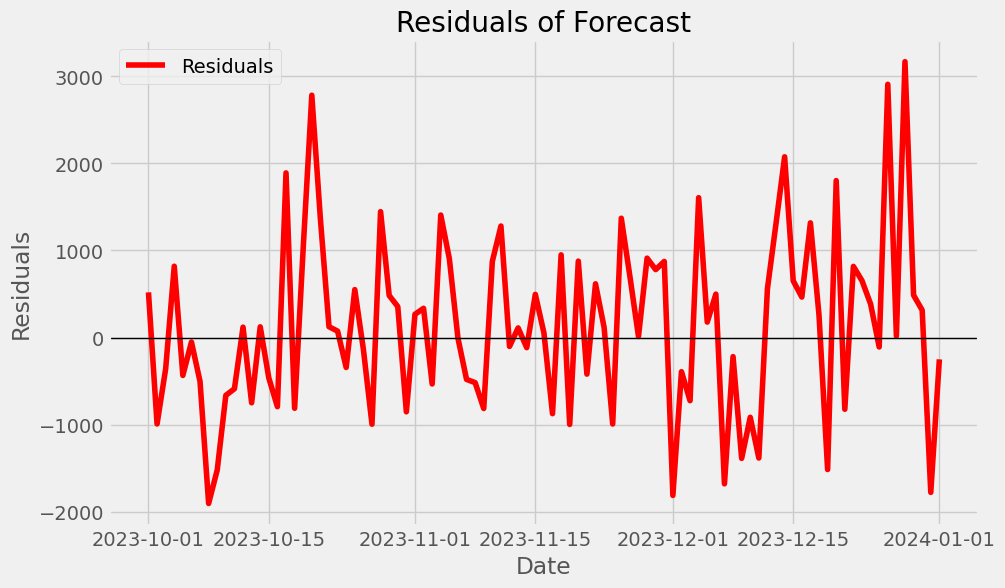

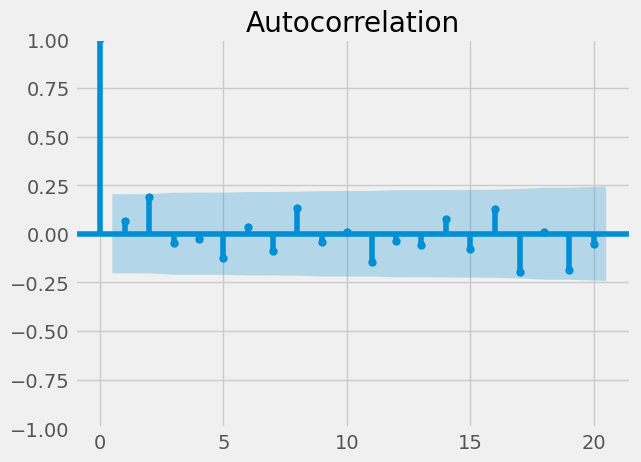

In [ ]:
# Residuals: Difference between true values and predicted values
residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(forecast_test['ds'], residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linewidth=1)
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Check the autocorrelation of residuals (if any)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.show()

# **LSTM Model**

In [ ]:
# Define lookback window (how many past steps to use for prediction)
lookback = 30

# Select features: Target ('y') + Regressors used in Prophet
features_to_scale = ['y', 'day_of_week', 'month', 'is_weekend']
target_col_name = 'y' # Explicitly define target column name
target_col_index = features_to_scale.index(target_col_name) # Find index of target

# Keras Tuner Settings
TUNER_DIRECTORY = 'lstm_tuning_dir_final'
TUNER_PROJECT_NAME = 'demand_forecast_lstm_final'
MAX_TRIALS = 15  # How many different hyperparameter sets to try
EXECUTIONS_PER_TRIAL = 1 # How many times to train each set (usually 1 is fine)
TUNER_EPOCHS = 50 # Max epochs during the tuning search phase

# Final Model Training Settings
FINAL_MODEL_EPOCHS = 100 # Max epochs for training the best model found
VALIDATION_SPLIT_RATIO = 0.2 # Use 20% of training data for validation during tuning & final training
EARLY_STOPPING_PATIENCE = 10 # Stop training if validation metric doesn't improve for this many epochs

print("LSTM Configuration Set:")
print(f"Lookback window: {lookback} days")
print(f"Features for LSTM: {features_to_scale}")
print(f"Target column index: {target_col_index}")

LSTM Configuration Set:
Lookback window: 30 days
Features for LSTM: ['y', 'day_of_week', 'month', 'is_weekend']
Target column index: 0


**Prepare Data Copies and Scale**

In [ ]:
# --- Prepare Data Specifically for LSTM ---

# Create copies of the relevant parts of train/test DFs to avoid modifying originals
# We use the train_df and test_df created earlier for Prophet
train_lstm_df = train_df[features_to_scale].copy()
test_lstm_df = test_df[features_to_scale].copy()

print(f"Shape of data prepared for LSTM training: {train_lstm_df.shape}")
print(f"Shape of data prepared for LSTM testing: {test_lstm_df.shape}")

# --- Scale the Data ---
# Scaling is crucial for LSTMs. Scale features to the range [0, 1].
# IMPORTANT: Fit the scaler ONLY on the training data to prevent data leakage.
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data and transform it
scaled_train_data = scaler.fit_transform(train_lstm_df)
print(f"\nShape of scaled training data: {scaled_train_data.shape}")

# Use the *same* fitted scaler to transform the test data
scaled_test_data = scaler.transform(test_lstm_df)
print(f"Shape of scaled test data: {scaled_test_data.shape}")

Shape of data prepared for LSTM training: (638, 4)
Shape of data prepared for LSTM testing: (93, 4)

Shape of scaled training data: (638, 4)
Shape of scaled test data: (93, 4)


**Sequence Creation Function**

In [ ]:
# --- Define Function to Create Input/Output Sequences ---

# This function converts the time series data into sequences suitable for LSTM input.
# For each sequence, X contains 'lookback' steps of all features,
# and y contains the target value at the step immediately following the sequence.

def create_sequences(data, lookback, target_index):
    """
    Creates sequences of data with a specified lookback window.

    Args:
        data (np.array): Scaled data array (samples, features).
        lookback (int): Number of previous time steps to use as input features.
        target_index (int): Index of the target variable column in the data array.

    Returns:
        tuple: A tuple containing:
            - np.array: Input sequences (X) with shape (samples, lookback, features).
            - np.array: Target values (y) with shape (samples,).
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        # Input sequence: Features from index i to i+lookback-1
        X.append(data[i:(i + lookback), :])
        # Target value: The target feature at index i+lookback
        y.append(data[i + lookback, target_index])
    return np.array(X), np.array(y)

print("`create_sequences` function defined.")

`create_sequences` function defined.


**Generate Training and Testing Sequences**

In [ ]:
# --- Create Training Sequences ---
X_train_seq, y_train_seq = create_sequences(scaled_train_data, lookback, target_col_index)
print("Shape of Training Sequences (X):", X_train_seq.shape) # Expected: (samples, lookback, num_features)
print("Shape of Training Targets (y):", y_train_seq.shape)

# --- Create Testing Sequences ---
# To create the first sequence for the test set, we need 'lookback' data points
# preceding the test set. We take these from the end of the training data.
combined_data_for_test_seq = np.concatenate((scaled_train_data[-lookback:], scaled_test_data), axis=0)

X_test_seq, y_test_seq = create_sequences(combined_data_for_test_seq, lookback, target_col_index)
print("\nShape of Testing Sequences (X):", X_test_seq.shape) # Expected: (samples, lookback, num_features)
print("Shape of Testing Targets (y):", y_test_seq.shape) # Corresponds to scaled test 'y' values

# --- Verification ---
num_features = len(features_to_scale)
expected_train_samples = len(scaled_train_data) - lookback
expected_test_samples = len(scaled_test_data) # Each test point should have a corresponding sequence/target

assert X_train_seq.shape[1:] == (lookback, num_features), "Train X dimensions incorrect!"
assert X_test_seq.shape[1:] == (lookback, num_features), "Test X dimensions incorrect!"
assert len(X_train_seq) == len(y_train_seq), "Train X and y length mismatch!"
assert len(X_test_seq) == len(y_test_seq), "Test X and y length mismatch!"
assert len(y_test_seq) == expected_test_samples, "Test y length mismatch with original test set size!"
print("\nSequence shapes and lengths verified.")

Shape of Training Sequences (X): (608, 30, 4)
Shape of Training Targets (y): (608,)

Shape of Testing Sequences (X): (93, 30, 4)
Shape of Testing Targets (y): (93,)

Sequence shapes and lengths verified.


**Define Tunable LSTM Model Function**

In [ ]:
# --- Define LSTM Model Building Function for Keras Tuner ---
# This function defines the structure of the LSTM model and the hyperparameters
# that Keras Tuner will optimize (e.g., number of units, dropout rate, optimizer, learning rate, architecture type).

from tensorflow.keras.layers import Bidirectional # Make sure Bidirectional is imported

# Define input shape based on created sequences: (timesteps, features)
input_shape_lstm = (lookback, X_train_seq.shape[2]) # e.g., (30, 4)

def build_tuned_lstm_model(hp):
    """Builds a tunable LSTM model (Simple, Stacked, or Bidirectional)."""
    model = Sequential(name="LSTM_TimeSeries_Model")
    model.add(Input(shape=input_shape_lstm, name="Input_Layer"))

    # --- Tune Architecture Type ---
    model_type = hp.Choice('model_type', ['simple', 'stacked', 'bidirectional'])

    # --- Tune Common Hyperparameters ---
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1)

    # --- Build Chosen Architecture ---
    if model_type == 'simple':
        model.add(LSTM(units=hp_units_1, activation='tanh', return_sequences=False, name="LSTM_Layer"))
        model.add(Dropout(rate=hp_dropout_1, name="Dropout_Layer"))

    elif model_type == 'stacked':
        # First LSTM layer (must return sequences for the next layer)
        model.add(LSTM(units=hp_units_1, activation='tanh', return_sequences=True, name="LSTM_Layer_1"))
        model.add(Dropout(rate=hp_dropout_1, name="Dropout_Layer_1"))
        # Second LSTM layer (tune units independently)
        hp_units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
        hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)
        model.add(LSTM(units=hp_units_2, activation='tanh', return_sequences=False, name="LSTM_Layer_2"))
        model.add(Dropout(rate=hp_dropout_2, name="Dropout_Layer_2"))

    elif model_type == 'bidirectional':
        model.add(Bidirectional(LSTM(units=hp_units_1, activation='tanh', return_sequences=False, name="BiLSTM_Layer")))
        model.add(Dropout(rate=hp_dropout_1, name="Dropout_Layer_Bi"))

    # --- Output Layer ---
    model.add(Dense(1, name="Output_Layer")) # Single output node for regression

    # --- Tune Optimizer and Learning Rate ---
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else: # optimizer_choice == 'rmsprop'
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # --- Compile Model ---
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error', # Suitable loss function for regression
        metrics=['mean_absolute_error'] # Track MAE during training/tuning
    )
    return model

print(f"LSTM model building function `build_tuned_lstm_model` defined for Keras Tuner.")
print(f"Expected input shape for LSTM: {input_shape_lstm}")

LSTM model building function `build_tuned_lstm_model` defined for Keras Tuner.
Expected input shape for LSTM: (30, 4)


**Initialize Keras Tuner**

In [ ]:
# --- Initialize Keras Tuner ---
# We use RandomSearch to explore the hyperparameter space defined in the build function.
# The objective is to minimize the validation MAE ('val_mean_absolute_error').

tuner = kt.RandomSearch(
    hypermodel=build_tuned_lstm_model, # The function that defines the model
    objective=kt.Objective("val_mean_absolute_error", direction="min"), # Goal: minimize validation MAE
    max_trials=MAX_TRIALS, # Number of different hyperparameter combinations to test
    executions_per_trial=EXECUTIONS_PER_TRIAL, # How many times to train each combination
    directory=TUNER_DIRECTORY, # Folder to save results
    project_name=TUNER_PROJECT_NAME,
    overwrite=True # Start fresh, delete previous tuner results in this directory
)

# Display a summary of the hyperparameters being tuned
tuner.search_space_summary()

Search space summary
Default search space size: 5
model_type (Choice)
{'default': 'simple', 'conditions': [], 'values': ['simple', 'stacked', 'bidirectional'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


**Run Keras Tuner Search**

In [ ]:
# --- Perform Hyperparameter Search ---
# The tuner trains different model versions on the training sequences,
# using a portion of it (validation_split) to evaluate performance and find the best HPs.
# EarlyStopping helps prevent overfitting and speeds up the search.

print("\n--- Starting Keras Tuner Hyperparameter Search ---")

# Define Early Stopping callback for the tuning process
stop_early_tuner = EarlyStopping(
    monitor='val_mean_absolute_error', # Metric to watch
    patience=EARLY_STOPPING_PATIENCE,  # Number of epochs with no improvement before stopping
    restore_best_weights=True # Restore model weights from the epoch with the best validation MAE
)

# Start the search process
# IMPORTANT: Do NOT use the test sequences (X_test_seq, y_test_seq) during tuning!
tuner.search(
    X_train_seq, y_train_seq,
    epochs=TUNER_EPOCHS, # Maximum epochs per trial
    validation_split=VALIDATION_SPLIT_RATIO, # Use part of training data for validation
    callbacks=[stop_early_tuner],
    verbose=1 # Show progress for each trial
)

print("\n--- Keras Tuner Search Complete ---")

# Display a summary of the top trial results
tuner.results_summary(num_trials=5) # Show top 5 best trials

Trial 15 Complete [00h 00m 12s]
val_mean_absolute_error: 0.12950856983661652

Best val_mean_absolute_error So Far: 0.12613248825073242
Total elapsed time: 00h 05m 46s

--- Keras Tuner Search Complete ---
Results summary
Results in lstm_tuning_dir_final/demand_forecast_lstm_final
Showing 5 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 12 summary
Hyperparameters:
model_type: simple
units_1: 96
dropout_1: 0.1
optimizer: adam
lr: 0.00011631525120543758
units_2: 16
dropout_2: 0.2
Score: 0.12613248825073242

Trial 03 summary
Hyperparameters:
model_type: stacked
units_1: 96
dropout_1: 0.1
optimizer: adam
lr: 0.0009018154359590027
units_2: 64
dropout_2: 0.4
Score: 0.12683643400669098

Trial 11 summary
Hyperparameters:
model_type: simple
units_1: 96
dropout_1: 0.4
optimizer: adam
lr: 0.001423015903577145
units_2: 16
dropout_2: 0.4
Score: 0.12747766077518463

Trial 10 summary
Hyperparameters:
model_type: simple
units_1: 96
dropout_1: 0.2
optimizer: adam
lr: 0.0017

**Get Best Hyperparameters & Build Final Model**

In [ ]:
# --- Retrieve Best Hyperparameters and Build the Final Model ---

# Get the hyperparameters object from the best trial found by the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] # Get the single best set of HPs

print("\n✅ Best Hyperparameters Found by Tuner:")
print(f"- Model Type: {best_hps.get('model_type')}")
print(f"- Optimizer: {best_hps.get('optimizer')}")
print(f"- Learning Rate: {best_hps.get('lr'):.5f}") # Format learning rate

# Print units and dropout based on the best model type found
best_model_type = best_hps.get('model_type')
print(f"- Units 1: {best_hps.get('units_1')}")
print(f"- Dropout 1: {best_hps.get('dropout_1'):.2f}")
if best_model_type == 'stacked':
    # These HPs only exist if 'stacked' was the best model type
    print(f"- Units 2: {best_hps.get('units_2')}")
    print(f"- Dropout 2: {best_hps.get('dropout_2'):.2f}")

# Build the final model using the best hyperparameters identified
print("\nBuilding final LSTM model with best hyperparameters...")
best_lstm_model = tuner.hypermodel.build(best_hps)

# Display the architecture of the final, best model
best_lstm_model.summary()


✅ Best Hyperparameters Found by Tuner:
- Model Type: simple
- Optimizer: adam
- Learning Rate: 0.00012
- Units 1: 96
- Dropout 1: 0.10

Building final LSTM model with best hyperparameters...


Model: "LSTM_TimeSeries_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer (LSTM)               │ (None, 96)             │        38,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,881 (151.88 KB)

 Trainable params: 38,881 (151.88 KB)

 Non-trainable params: 0 (0.00 B)

** Train Final LSTM Model**

In [ ]:
# --- Train the Final LSTM Model ---
# Now, train the best model configuration on the *entire* training sequence dataset.
# We still use a validation split to monitor for overfitting during this final training phase.

print("\n--- Training Final LSTM Model on Full Training Data ---")

# Re-initialize Early Stopping for final training (often monitor 'val_loss')
stop_early_final = EarlyStopping(
    monitor='val_loss', # Monitor validation loss (MSE)
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True # Restore weights from the best epoch based on val_loss
)

# Train the model
history = best_lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=FINAL_MODEL_EPOCHS, # Train for potentially more epochs than during tuning
    validation_split=VALIDATION_SPLIT_RATIO, # Monitor performance on validation set
    callbacks=[stop_early_final],
    verbose=1 # Show training progress
)

print("\n--- Final LSTM Model Training Complete ---")


--- Training Final LSTM Model on Full Training Data ---
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.1902 - mean_absolute_error: 0.4037 - val_loss: 0.0995 - val_mean_absolute_error: 0.2733
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0874 - mean_absolute_error: 0.2589 - val_loss: 0.0380 - val_mean_absolute_error: 0.1600
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0451 - mean_absolute_error: 0.1725 - val_loss: 0.0285 - val_mean_absolute_error: 0.1327
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0333 - mean_absolute_error: 0.1458 - val_loss: 0.0278 - val_mean_absolute_error: 0.1321
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0283 - mean_absolute_error: 0.1298 - val_loss: 0.0267 - val_mean_absolute_error: 0.1310
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0292 - mean_absolute_error: 0.1355 - val_loss: 0.0264 - val_mean_absolute_error: 0.1308
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
# --- Evaluate Final LSTM Model Performance on Unseen Test Data ---
# Make predictions on the test sequences and inverse transform to the original scale.
# Calculate standard regression metrics (RMSE, MAE, MAPE).

print("\n--- Evaluating Final LSTM Model on Test Set ---")

# 1. Make predictions (output will be scaled) using the overall best model
predictions_scaled = best_lstm_model.predict(X_test_seq)

# 2. Inverse Transform Predictions and Actuals
num_features_scaled = scaled_train_data.shape[1]
dummy_pred = np.zeros((len(predictions_scaled), num_features_scaled))
dummy_true = np.zeros((len(y_test_seq), num_features_scaled))
dummy_pred[:, target_col_index] = predictions_scaled.ravel()
dummy_true[:, target_col_index] = y_test_seq.ravel()
predictions_original_scale = scaler.inverse_transform(dummy_pred)[:, target_col_index]
y_test_original_scale = scaler.inverse_transform(dummy_true)[:, target_col_index]

# 3. Calculate Evaluation Metrics for the overall best model
lstm_rmse = np.sqrt(mean_squared_error(y_test_original_scale, predictions_original_scale))
lstm_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
lstm_mape = mean_absolute_percentage_error(y_test_original_scale, predictions_original_scale)

print(f"\nOverall Best LSTM ({best_model_type.capitalize()}) Test Set Performance (Original Scale):") # Clarify this is the overall best
print(f"RMSE: {lstm_rmse:.2f}")
print(f"MAE:  {lstm_mae:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")

# Store LSTM results for the final comparison table
final_lstm_metrics = {
    'Model': f'LSTM ({best_model_type.capitalize()}, Tuned - Overall Best)', # Be specific
    'RMSE': round(lstm_rmse, 2),
    'MAE': round(lstm_mae, 2),
    'MAPE': round(lstm_mape, 2)
}
print("\nStored metrics for the overall best LSTM model.")


--- Evaluating Final LSTM Model on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Overall Best LSTM (Simple) Test Set Performance (Original Scale):
RMSE: 1002.18
MAE:  779.51
MAPE: 5.50%

Stored metrics for the overall best LSTM model.


Build and Train a Specific Bidirectional Model

In [ ]:
# --- Build and Train a Specific Bidirectional Model for Comparison ---
print("\n--- Building and Training a Specific Bidirectional LSTM ---")

# Use HPs from the overall best run as a starting point, but force model_type
forced_bi_hps = best_hps.copy() # Start with best HPs

# Manually construct the BiLSTM model structure
forced_bi_model = Sequential(name="Forced_BiLSTM_Model")
forced_bi_model.add(Input(shape=input_shape_lstm, name="Input_Layer"))
forced_bi_model.add(Bidirectional(LSTM(units=forced_bi_hps.get('units_1'), # Use tuned units_1
                                        activation='tanh',
                                        return_sequences=False, # Usually False for last layer before Dense
                                        name="BiLSTM_Layer")))
# Use dropout_1, as BiLSTM in the tuner function only had one dropout layer specified this way
forced_bi_model.add(Dropout(rate=forced_bi_hps.get('dropout_1'), name="Dropout_Layer_Bi"))
forced_bi_model.add(Dense(1, name="Output_Layer"))

# Compile using tuned optimizer and LR from the best overall run
if forced_bi_hps.get('optimizer') == 'adam':
    optimizer_forced = tf.keras.optimizers.Adam(learning_rate=forced_bi_hps.get('lr'))
else:
    optimizer_forced = tf.keras.optimizers.RMSprop(learning_rate=forced_bi_hps.get('lr'))
forced_bi_model.compile(optimizer=optimizer_forced, loss='mean_squared_error', metrics=['mean_absolute_error'])

print("\nForced Bidirectional Model Architecture:")
forced_bi_model.summary()

# Train this specific model
print("\nTraining the forced Bidirectional model...")
stop_early_forced = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
history_forced_bi = forced_bi_model.fit(
    X_train_seq, y_train_seq,
    epochs=FINAL_MODEL_EPOCHS, # Use same epoch count for fairness
    validation_split=VALIDATION_SPLIT_RATIO,
    callbacks=[stop_early_forced],
    verbose=0 # Set verbose=0 to keep output clean, or 1 to see progress
)
print("--- Forced Bidirectional Model Training Complete ---")


--- Building and Training a Specific Bidirectional LSTM ---

Forced Bidirectional Model Architecture:


Model: "Forced_BiLSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 192)            │        77,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_Bi (Dropout)      │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,761 (303.75 KB)

 Trainable params: 77,761 (303.75 KB)

 Non-trainable params: 0 (0.00 B)


Training the forced Bidirectional model...
--- Forced Bidirectional Model Training Complete ---


In [ ]:
# --- Evaluate the Forced Bidirectional Model ---
print("\n--- Evaluating Forced Bidirectional LSTM on Test Set ---")

# 1. Make predictions using the specifically trained BiLSTM model
predictions_scaled_forced_bi = forced_bi_model.predict(X_test_seq)

# 2. Inverse transform predictions (actuals are the same: y_test_original_scale)
dummy_pred_forced_bi = np.zeros((len(predictions_scaled_forced_bi), num_features_scaled))
dummy_pred_forced_bi[:, target_col_index] = predictions_scaled_forced_bi.ravel()
predictions_original_forced_bi = scaler.inverse_transform(dummy_pred_forced_bi)[:, target_col_index]

# y_test_original_scale was calculated in Cell 10 and remains the same ground truth

# 3. Calculate metrics for this specific BiLSTM model
bi_lstm_rmse = np.sqrt(mean_squared_error(y_test_original_scale, predictions_original_forced_bi))
bi_lstm_mae = mean_absolute_error(y_test_original_scale, predictions_original_forced_bi)
bi_lstm_mape = mean_absolute_percentage_error(y_test_original_scale, predictions_original_forced_bi)

print("\nForced Bidirectional LSTM Test Set Performance (Original Scale):")
print(f"RMSE: {bi_lstm_rmse:.2f}")
print(f"MAE:  {bi_lstm_mae:.2f}")
print(f"MAPE: {bi_lstm_mape:.2f}%")

# Store metrics for comparison table
final_bi_lstm_metrics = {
    'Model': 'LSTM (Bidirectional, Specific Eval)', # Clear label
    'RMSE': round(bi_lstm_rmse, 2),
    'MAE': round(bi_lstm_mae, 2),
    'MAPE': round(bi_lstm_mape, 2)
}
print("\nStored metrics for the specifically evaluated Bidirectional LSTM model.")


--- Evaluating Forced Bidirectional LSTM on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step

Forced Bidirectional LSTM Test Set Performance (Original Scale):
RMSE: 1015.99
MAE:  786.92
MAPE: 5.54%

Stored metrics for the specifically evaluated Bidirectional LSTM model.


Plot Training History - Plots the Overall Best Model's History


--- Plotting LSTM Training History ---


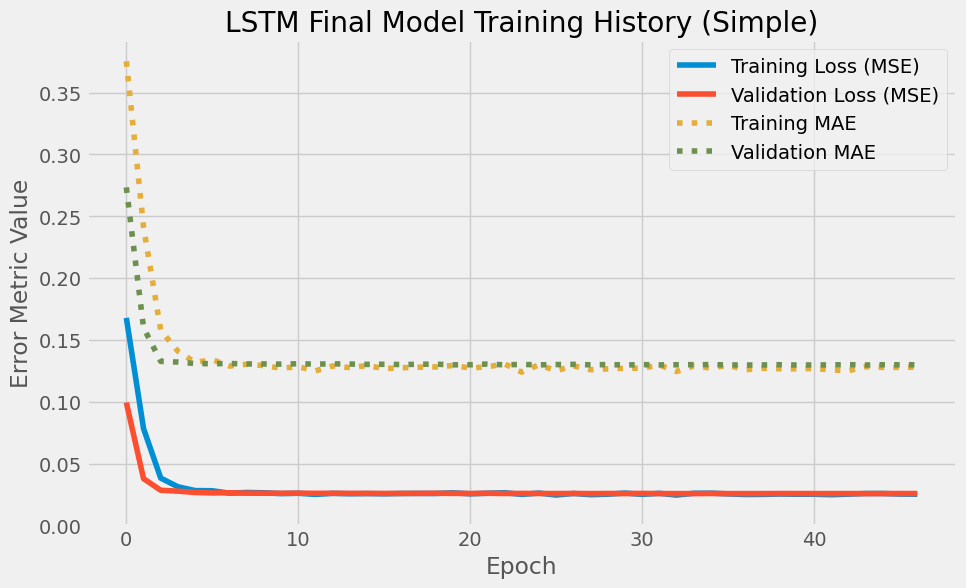

In [ ]:
# --- Plot LSTM Training & Validation Loss Curves ---
# Visualizing the loss helps understand if the model trained well and if overfitting occurred.

print("\n--- Plotting LSTM Training History ---")
plt.figure(figsize=(10, 6))

# Plot training and validation loss (MSE)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')

# Optionally plot MAE if tracked
if 'mean_absolute_error' in history.history:
    plt.plot(history.history['mean_absolute_error'], label='Training MAE', linestyle=':')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', linestyle=':')

plt.title(f'LSTM Final Model Training History ({best_model_type.capitalize()})')
plt.xlabel('Epoch')
plt.ylabel('Error Metric Value')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Loss/Error metrics shouldn't be negative
plt.show()


--- Plotting LSTM Predictions vs Actuals (Test Set) ---


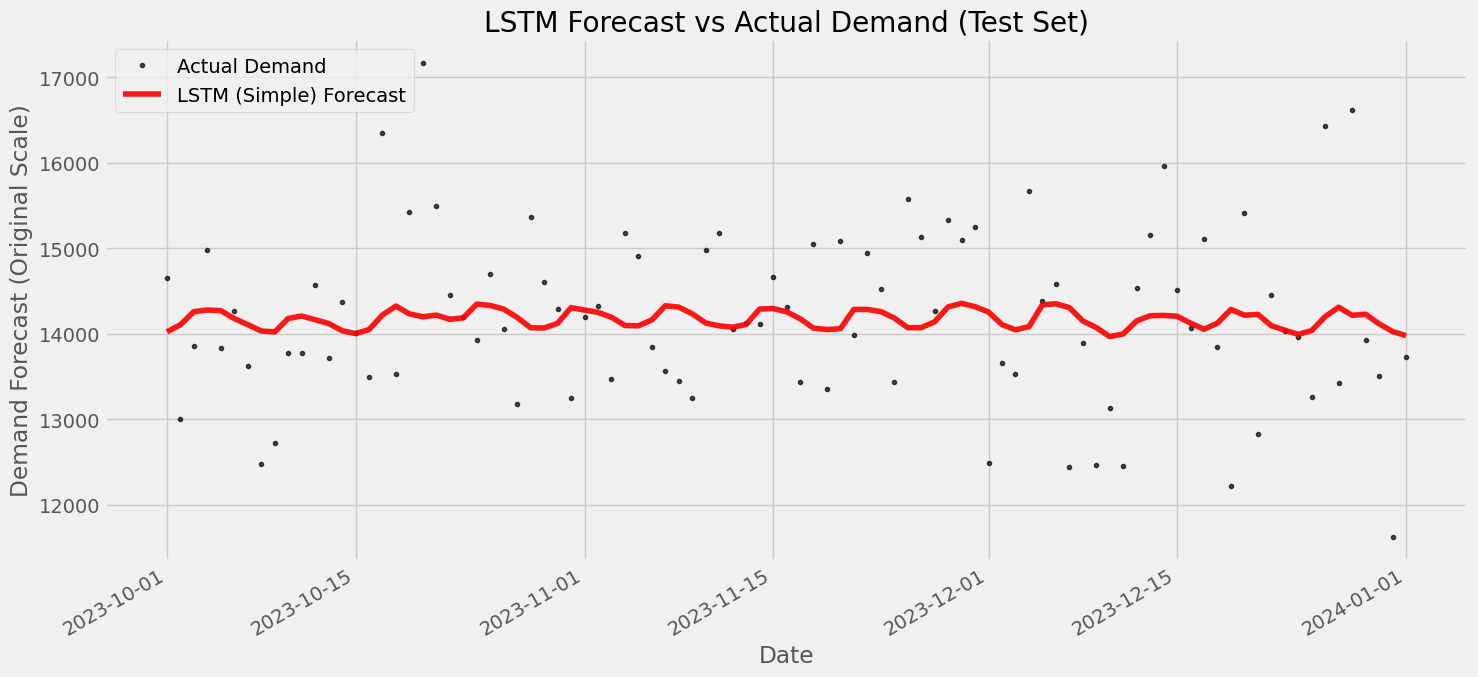

In [ ]:
# --- Plot LSTM Predictions vs Actual Values for the Test Set ---
# This visual comparison shows how well the model's forecast matches the real data.

print("\n--- Plotting LSTM Predictions vs Actuals (Test Set) ---")

# Get the dates corresponding to the test set predictions/actuals
# y_test_original_scale corresponds directly to the test_df 'y' values after the lookback period adjustment
# Ensure test_dates align with the predictions. Since X_test_seq/y_test_seq represent predictions
# *after* the sequence, they align directly with the dates in test_df.
test_dates = test_df['ds'].reset_index(drop=True)

# Ensure lengths match before plotting
if len(test_dates) == len(y_test_original_scale) == len(predictions_original_scale):
    plt.figure(figsize=(15, 7))
    plt.plot(test_dates, y_test_original_scale, label='Actual Demand', color='black', marker='.', linestyle='None', alpha=0.7)
    plt.plot(test_dates, predictions_original_scale, label=f'LSTM ({best_model_type.capitalize()}) Forecast', color='red', linestyle='-', alpha=0.9)
    plt.title('LSTM Forecast vs Actual Demand (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Demand Forecast (Original Scale)')
    plt.legend()
    plt.grid(True)
    # Format the x-axis for dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) # Auto-adjust date ticks
    plt.gcf().autofmt_xdate() # Rotate date labels automatically
    plt.tight_layout()
    plt.show()
else:
    print("Error: Length mismatch prevents plotting.")
    print(f"Test Dates: {len(test_dates)}, Actuals: {len(y_test_original_scale)}, Predictions: {len(predictions_original_scale)}")

**Prophet and LSTM Models Comparison**

In [ ]:
# Ensure the 'final_prophet_metrics' dictionary from the Prophet section exists

# Ensure the metrics for the specific BiLSTM evaluation exist

# Ensure the metrics for the hyperopt Prophet model exist
#if 'final_hyperopt_prophet_metrics' not in locals() and 'final_hyperopt_prophet_metrics' not in globals():
#     print("Warning: 'final_hyperopt_prophet_metrics' not found. Using placeholder.")
#     final_hyperopt_prophet_metrics = {'Model': 'Prophet (Hyperopt Tuned)', 'RMSE': 0.0, 'MAE': 0.0, 'MAPE': 0.0} # Placeholder

# Create a list of all metrics dictionaries (including the hyperopt one)
all_metrics = [
    final_prophet_metrics,          # Best from manual CPS tuning
    final_hyperopt_prophet_metrics, # Best from hyperopt tuning
    final_bi_lstm_metrics,          # Specifically evaluated BiLSTM
    final_lstm_metrics,             # Best overall LSTM
]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(all_metrics)

# Display the comparison table, using the 'Model' column as the index
print(comparison_df.set_index('Model'))

                                        RMSE     MAE  MAPE
Model                                                     
Prophet (cps=0.1)                    1021.48  797.68  5.60
Prophet (Hyperopt Tuned)             1034.35  807.38  5.65
LSTM (Bidirectional, Specific Eval)  1015.99  786.92  5.54
LSTM (Simple, Tuned - Overall Best)  1002.18  779.51  5.50


GIT and MLFLOW

In [ ]:
!git init
!git add .
!git commit -m "Initial commit of project code"

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@5ea4f90c1335.(none)')


In [ ]:
pip install mlflow dvc dvc[gdrive]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.7/457.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━

In [ ]:
!dvc init

Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


In [ ]:
!git config --global user.email "mohamed.abdelrazek@ejust.edu.eg"
!git config --global user.name "Mohamed"

In [ ]:
!git add .dvc .gitignore
!git commit -m "Initialize DVC"

fatal: pathspec '.gitignore' did not match any files
[master (root-commit) d908ebb] Initialize DVC
 73 files changed, 124170 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.04.23/13.38.26.733387.log
 create mode 100644 .config/logs/2025.04.23/13.38.55.951136.log
 create mode 100644 .config/logs/2025.04.23/13.39.04.100569.log
 create mode 100644 .config/logs/2025.04.23/13.39.08.705092.log
 create mode 100644 .config/logs/2025.04.23/13.39.17.107858.log
 create mode 100644 .config/logs/2025.04.23/13.39.17.778447.log
 crea

In [ ]:
!dvc remote list

gdrive	gdrive://1G5LV4DqHw0tDP6EehmX8kFU7ZurQbEtu
local	/path/to/your/dvc_storage


In [ ]:
!dvc remote default

local


In [ ]:
!dvc remote add -d --force gdrive gdrive://1G5LV4DqHw0tDP6EehmX8kFU7ZurQbEtu

Setting 'gdrive' as a default remote.


In [ ]:
!git add .dvc/config
!git commit -m "Configure DVC remote storage (Google Drive)"

On branch master
nothing to commit, working tree clean


In [ ]:
!dvc remote modify gdrive default true
!git add .dvc/config
!git commit -m "Set gdrive as default DVC remote"

ERROR: configuration error - config file error: extra keys not allowed @ data['remote']['gdrive']['default']
[master c56b6b0] Set gdrive as default DVC remote
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
# Create a folder in your Google Drive for DVC storage (e.g., "SalesForecastDVC")
# Get the folder ID from the URL (the long string after /folders/)
!dvc remote add -d gdrive gdrive://1G5LV4DqHw0tDP6EehmX8kFU7ZurQbEtu
!git add .dvc/config # Add the updated config file
!git commit -m "Configure DVC remote storage (Google Drive)"
# The first time you push/pull, DVC will guide you through authentication.

Setting 'gdrive' as a default remote.
ERROR: configuration error - config file error: remote 'gdrive' already exists. Use `-f|--force` to overwrite it.
On branch master
nothing to commit, working tree clean


In [ ]:
# Create a directory outside your project folder for storage
# Example: /path/to/your/dvc_storage
!dvc remote add -d local /path/to/your/dvc_storage
!git add .dvc/config
!git commit -m "Configure DVC remote storage (local)"

Setting 'local' as a default remote.
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@5ea4f90c1335.(none)')


In [ ]:
!mkdir data
!mv retail_store_inventory.csv data/
!git add data/ # Tell git to track the directory, even if DVC ignores the content later
!git commit -m "Organize data into data/ directory"

[master 0f260a9] Organize data into data/ directory
 1 file changed, 73101 insertions(+)
 create mode 100644 data/retail_store_inventory.csv


In [ ]:
!dvc add data/retail_store_inventory.csv

⠋ Checking graph
Adding...:   0% 0/1 [00:00<?, ?file/s{'info': ''}]
!
          |0.00 [00:00,     ?file/s]
Adding...:   0% 0/1 [00:00<?, ?file/s{'info': ''}]
ERROR:  output 'data/retail_store_inventory.csv' is already tracked by SCM (e.g. Git).
    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached 'data/retail_store_inventory.csv'
            git commit -m "stop tracking data/retail_store_inventory.csv" 


In [ ]:
!git add data/retail_store_inventory.csv.dvc .gitignore
!git commit -m "Track raw dataset with DVC"

fatal: pathspec 'data/retail_store_inventory.csv.dvc' did not match any files
On branch master
Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    retail_store_inventory.csv

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!dvc push

Pushing
Everything is up to date.


In [ ]:
import mlflow
import mlflow.prophet
import mlflow.tensorflow
from sklearn.metrics import mean_squared_error, mean_absolute_error # Ensure these are imported
# Your MAPE function definition should be available

# --- Example: Wrapping Prophet CPS Tuning Loop ---
changepoint_scales_to_try = [0.01, 0.05, 0.1, 0.5]
results = [] # Keep this for local results table if desired

for scale in changepoint_scales_to_try:
    # Start an MLflow run for each scale
    with mlflow.start_run(run_name=f"Prophet_CPS_{scale}"): # Give runs meaningful names
        print(f"--- Training with changepoint_prior_scale = {scale} ---")

        # Log the parameter being tuned
        mlflow.log_param("changepoint_prior_scale", scale)
        mlflow.log_param("model_type", "Prophet") # Log model type

        # --- Your existing model initialization and training code ---
        m_tuned = Prophet(
            holidays=holiday_df,
            changepoint_prior_scale=scale,
        )
        m_tuned.add_regressor('day_of_week')
        m_tuned.add_regressor('month')
        m_tuned.add_regressor('is_weekend')
        m_tuned.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])
        # --- End of existing training code ---

        # --- Your existing prediction code ---
        future_tuned = m_tuned.make_future_dataframe(periods=len(test_df), freq='D', include_history=False)
        future_tuned = test_df[['ds', 'day_of_week', 'month', 'is_weekend']].merge(future_tuned, on='ds', how='inner')
        forecast_tuned = m_tuned.predict(future_tuned[['ds', 'day_of_week', 'month', 'is_weekend']])
        # --- End of existing prediction code ---

        # --- Your existing evaluation code ---
        y_true_eval = test_df['y'].values
        y_pred_eval = forecast_tuned['yhat'].values
        rmse_eval = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))
        mae_eval = mean_absolute_error(y_true_eval, y_pred_eval)
        mape_eval = mean_absolute_percentage_error(y_true_eval, y_pred_eval)
        # --- End of existing evaluation code ---

        # Log metrics to MLflow
        mlflow.log_metric("rmse", rmse_eval)
        mlflow.log_metric("mae", mae_eval)
        mlflow.log_metric("mape", mape_eval)

        print(f"Metrics: RMSE={rmse_eval:.2f}, MAE={mae_eval:.2f}, MAPE={mape_eval:.2f}%")

        # Log the Prophet model using the MLflow flavor
        # This saves the model in a standard format and logs it as an artifact
        mlflow.prophet.log_model(m_tuned, artifact_path="prophet-model")

        # (Optional) Log plots or other artifacts
        # fig = m_tuned.plot(forecast_tuned)
        # plt.savefig("forecast_plot.png")
        # mlflow.log_artifact("forecast_plot.png")
        # plt.close(fig) # Close plot to free memory

        print("-" * 40)

    # Append results to local list (optional)
    results.append({
        'Model': f'Prophet (cps={scale})', 'RMSE': round(rmse_eval, 2),
        'MAE': round(mae_eval, 2), 'MAPE': round(mape_eval, 2)
    })

# --- Similarly wrap your hyperopt section ---
# In the objective function or after finding the best model:
# with mlflow.start_run(run_name="Prophet_Hyperopt_Best"):
#    mlflow.log_params(best) # Log best hyperopt params
#    # ... retrain best model ...
#    mlflow.log_metric("rmse", final_rmse)
#    mlflow.log_metric("mae", final_mae)
#    mlflow.log_metric("mape", final_mape)
#    mlflow.prophet.log_model(best_model, artifact_path="prophet-hyperopt-model")


# --- Example: Wrapping Final LSTM Training ---
# After finding best HPs with Keras Tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_lstm_model = tuner.hypermodel.build(best_hps)

with mlflow.start_run(run_name="LSTM_Final_Training"):
    # Log best hyperparameters found by tuner
    mlflow.log_params(best_hps.values) # Log all HPs from the best trial
    mlflow.log_param("lookback_window", lookback) # Log other relevant params

    # --- Your existing final LSTM training code ---
    history = best_lstm_model.fit(...)
    # --- End of existing training code ---

    # --- Your existing LSTM evaluation code ---
    predictions_scaled = best_lstm_model.predict(X_test_seq)
    # ... inverse scaling ...
    lstm_rmse = np.sqrt(mean_squared_error(y_test_original_scale, predictions_original_scale))
    lstm_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
    lstm_mape = mean_absolute_percentage_error(y_test_original_scale, predictions_original_scale)
    # --- End of existing evaluation code ---

    # Log final test metrics
    mlflow.log_metric("final_test_rmse", lstm_rmse)
    mlflow.log_metric("final_test_mae", lstm_mae)
    mlflow.log_metric("final_test_mape", lstm_mape)

    # Log the TensorFlow/Keras model
    mlflow.tensorflow.log_model(best_lstm_model, artifact_path="lstm-model")

    # (Optional) Log training history plot
    # plt.figure()
    # plt.plot(...)
    # plt.savefig("lstm_history.png")
    # mlflow.log_artifact("lstm_history.png")
    # plt.close()

# --- Do similar logging for the specific BiLSTM evaluation run ---

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/frlln4st.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/a6fs6tuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61178', 'data', 'file=/tmp/tmp9tthk61y/frlln4st.json', 'init=/tmp/tmp9tthk61y/a6fs6tuc.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelrtylj7dn/prophet_model-20250424213618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Training with changepoint_prior_scale = 0.01 ---
Metrics: RMSE=1027.72, MAE=799.53, MAPE=5.60%


2025/04/24 21:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/nmyzw5li.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/ey1dn34y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74679', 'data', 'file=/tmp/tmp9tthk61y/nmyzw5li.json', 'init=/tmp/tmp9tthk61y/ey1dn34y.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_model173_k48p/prophet_model-20250424213622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:22 - cmdstanpy - INFO - Chain [1] 

----------------------------------------
--- Training with changepoint_prior_scale = 0.05 ---
Metrics: RMSE=1024.59, MAE=798.55, MAPE=5.60%
----------------------------------------


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/fp01f6i9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/ma3d1ykj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51547', 'data', 'file=/tmp/tmp9tthk61y/fp01f6i9.json', 'init=/tmp/tmp9tthk61y/ma3d1ykj.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelx3j4wm_l/prophet_model-20250424213622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Training with changepoint_prior_scale = 0.1 ---
Metrics: RMSE=1021.48, MAE=797.68, MAPE=5.60%


2025/04/24 21:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/e008yi54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9tthk61y/h_w8d3sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13171', 'data', 'file=/tmp/tmp9tthk61y/e008yi54.json', 'init=/tmp/tmp9tthk61y/h_w8d3sl.json', 'output', 'file=/tmp/tmp9tthk61y/prophet_modelw5ren4ma/prophet_model-20250424213622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:22 - cmdstanpy - INFO - Chain [1] 

----------------------------------------
--- Training with changepoint_prior_scale = 0.5 ---


2025/04/24 21:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Metrics: RMSE=1017.30, MAE=798.10, MAPE=5.64%
----------------------------------------


ValueError: Unrecognized data type: x=Ellipsis (of type <class 'ellipsis'>)

In [ ]:
mlflow ui

In [ ]:
# Example for LSTM
best_lstm_model.save("models/best_lstm_model.h5")

In [ ]:
dvc add models/best_lstm_model.h5

In [ ]:
git add models/best_lstm_model.h5.dvc models/.gitignore # DVC might update .gitignore for models/
git commit -m "Track trained LSTM model v1 with DVC"

In [ ]:
dvc push

In [ ]:
git add your_notebook.ipynb # Or your .py script
git commit -m "Integrate MLflow tracking for experiments"